In [1]:
import json
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt
import warnings

# plotting params
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.grid': True,
    'grid.alpha': 0.6,
    'grid.linestyle': '--',
    'font.size': 14,
    "figure.dpi": 200,
})

# Suppress a harmless warning from the vector library with awkward arrays
warnings.filterwarnings("ignore", message="Passing an awkward array to a ufunc")

# Register the vector library with awkward array
ak.behavior.update(vector.backends.awkward.behavior)

# --- 1. CONFIGURATION ---
# All user-changable settings are here.
with open("hh-bbbb-obj-config.json", "r") as config_file:
    CONFIG = json.load(config_file)

# --- 2. DATA LOADING & PREPARATION FUNCTIONS ---
from data_loading_helpers import load_and_prepare_data, select_gen_b_quarks_from_higgs

# --- 3. ANALYSIS FUNCTIONS ---
from analysis_helpers import *

# --- 4. PLOTTING FUNCTIONS ---
from plotting_helpers import *

# --- 5. SELECTION CUT FUNCTIONS ---
def apply_custom_cuts(reco_jets, config, key, kinematic_only=False):
    """
    Apply custom cuts to a jet collection.

    Parameters
    ----------
    reco_jets : awkward.Array
        Jet collection (offline or L1).
    config : dict
        Global CONFIG dict.
    key : str
        Either "offline" or "l1" to select the appropriate config.
    kinematic_only : bool
        If True, only apply kinematic cuts, i.e., pt and eta cuts
        If False, apply custom tagger cuts as well
    """
    subcfg = config[key]

    pt_cut = subcfg["pt_cut"]
    eta_cut = subcfg["eta_cut"]
    b_tag_cut = subcfg["b_tag_cut"]
    tagger_name = subcfg["tagger_name"]

    print(f"\nApplying custom pT cut of {pt_cut} GeV for {key} jets...")
    pt_mask = reco_jets.pt > pt_cut
    eta_mask = abs(reco_jets.eta) < eta_cut
    final_mask = pt_mask & eta_mask

    if kinematic_only:
        pass
    else:
        print(f"Applying custom cuts for {tagger_name} ({key})...")

        if key == "offline":
            charm_veto_cut = subcfg["charm_veto_cut"]
            electron_veto_cut = subcfg["electron_veto_cut"]
            muon_veto_cut = subcfg["muon_veto_cut"]

            if tagger_name.startswith("btagPNet"):
                b_jet_mask = (reco_jets.btagPNetB > b_tag_cut)
                charm_veto_mask = (reco_jets.btagPNetCvB < charm_veto_cut)
                final_mask = final_mask & charm_veto_mask & b_jet_mask

            elif tagger_name.startswith("btagUParTAK4"):
                b_jet_mask = (reco_jets.btagUParTAK4probb > b_tag_cut)
                charm_veto_mask = (reco_jets.btagUParTAK4CvB < charm_veto_cut)
                electron_veto_mask = (reco_jets.btagUParTAK4Ele < electron_veto_cut)
                muon_veto_mask = (reco_jets.btagUParTAK4Mu < muon_veto_cut)
                final_mask = (
                    final_mask
                    & charm_veto_mask
                    & electron_veto_mask
                    & muon_veto_mask
                    & b_jet_mask
                )

        elif key == "l1ng":
            # For L1, just apply the tagger cut generically
            tag_mask = getattr(reco_jets, tagger_name) > b_tag_cut
            final_mask = final_mask & tag_mask

        elif key == "l1ext":
            tag_mask = getattr(reco_jets, tagger_name) > b_tag_cut
            final_mask = final_mask & tag_mask

    reco_jets = reco_jets[final_mask]
    return reco_jets



/Users/adityatandon/Documents/College/Physics/Year 4/Neural SBI/root-obj-perf/plotting_helpers.py:195: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  plt.title(f"Average CvB score ({tagger_name}) vs. $p_T$ and $\eta$")
/Users/adityatandon/Documents/College/Physics/Year 4/Neural SBI/root-obj-perf/plotting_helpers.py:465: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  plt.errorbar(bin_centers, widths, yerr=errors, fmt='o-', capsize=5, label='Resolution ($\sigma$)')


Loading data from /Users/adityatandon/Documents/College/Physics/Year 4/Neural SBI/root-obj-perf/data/hh4b_puppi_pf/hh4b/data_*.root...
Reshaping data into nested objects...
Creating 4-vector objects...
Applying pT regression corrections to Jet btagPNetB...
Loaded and restructured 50000 events.
Loading data from /Users/adityatandon/Documents/College/Physics/Year 4/Neural SBI/root-obj-perf/data/hh4b_puppi_pf/hh4b/data_*.root...


/opt/anaconda3/envs/hep-root-ml/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:289: RuntimeWarning: overflow encountered in cosh
  return impl(*broadcasted_args, **(kwargs or {}))
/opt/anaconda3/envs/hep-root-ml/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:289: RuntimeWarning: invalid value encountered in multiply
  return impl(*broadcasted_args, **(kwargs or {}))


Reshaping data into nested objects...
Creating 4-vector objects...
Applying pT regression corrections to Jet btagUParTAK4B...
Loaded and restructured 50000 events.
Selecting gen-level b-quarks...
Found 200000 b-quarks from Higgs decays.

Applying custom pT cut of 25.0 GeV for offline jets...
Applying custom cuts for btagPNetB (offline)...

Applying custom pT cut of 25.0 GeV for offline jets...
Applying custom cuts for btagUParTAK4B (offline)...

Applying custom pT cut of 25.0 GeV for l1ng jets...
Applying custom cuts for b_v_udscg_score (l1ng)...

Applying custom pT cut of 25.0 GeV for l1ext jets...
Applying custom cuts for btagScore (l1ext)...
Plotting reconstruction efficiencies for L1NG vs L1ExtJet...


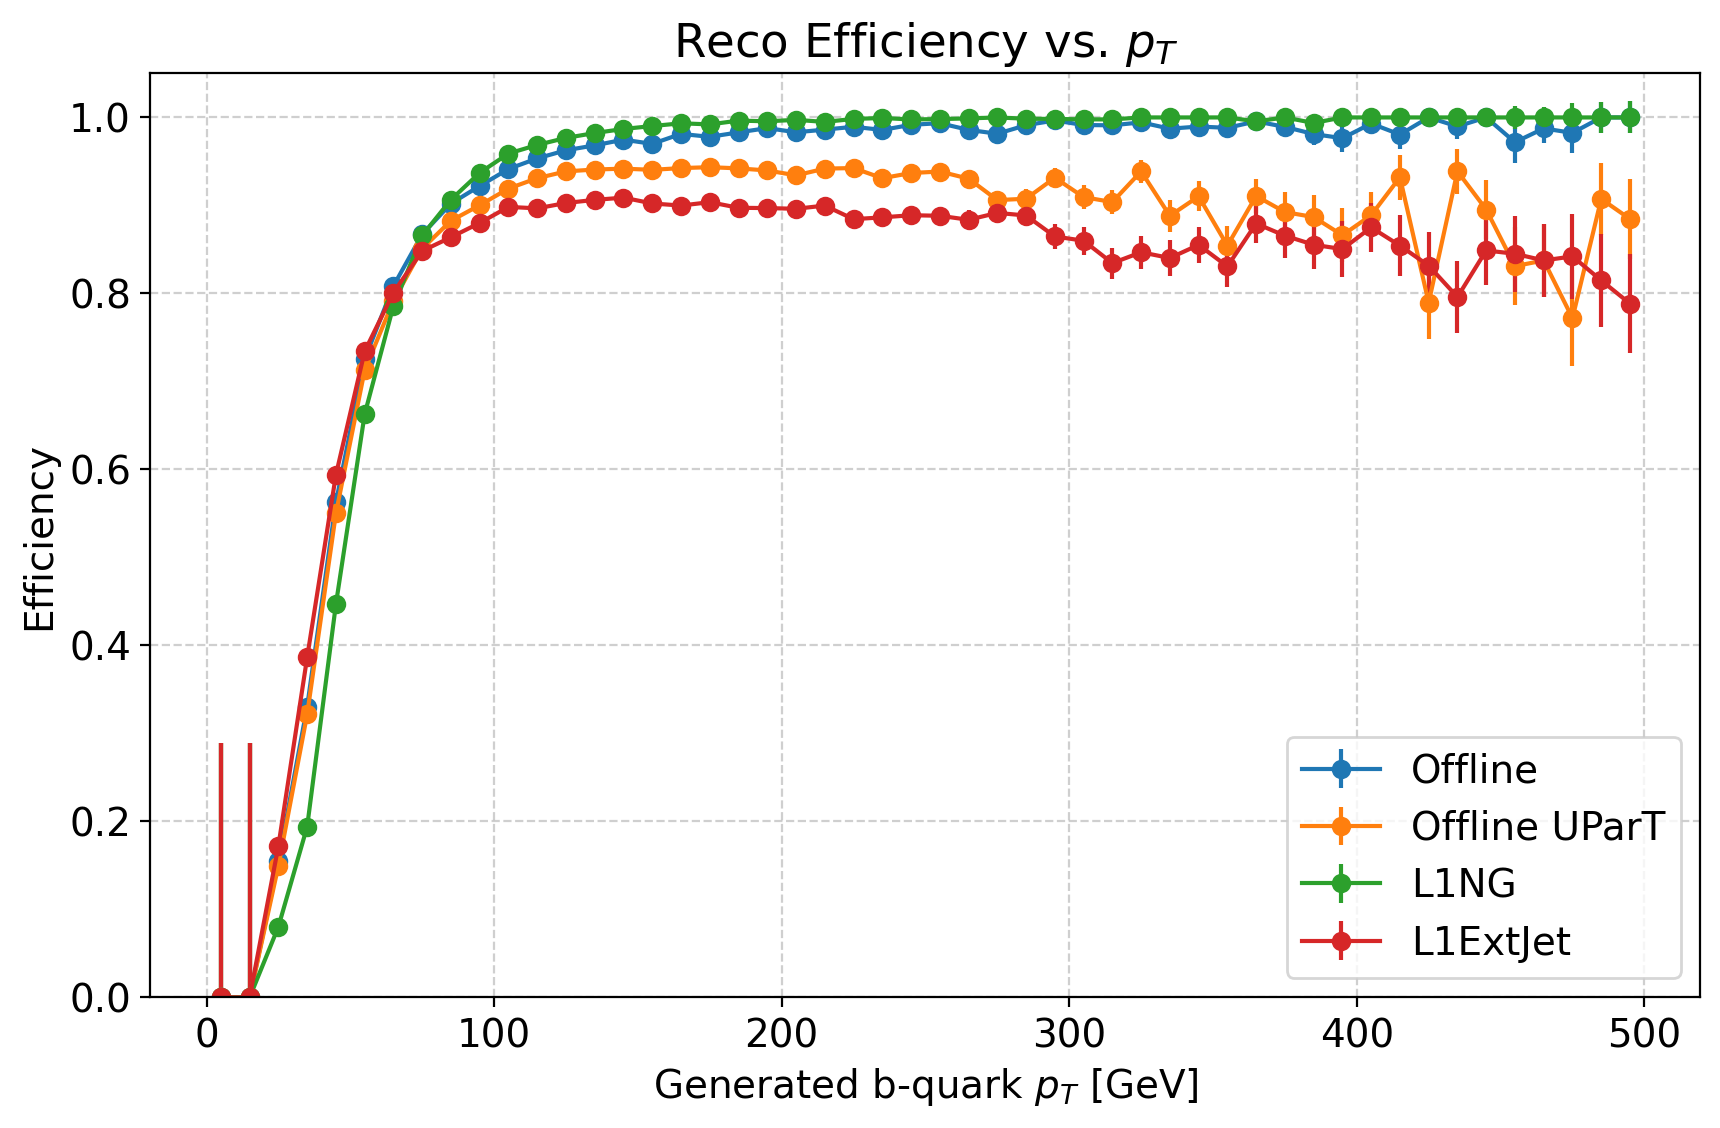

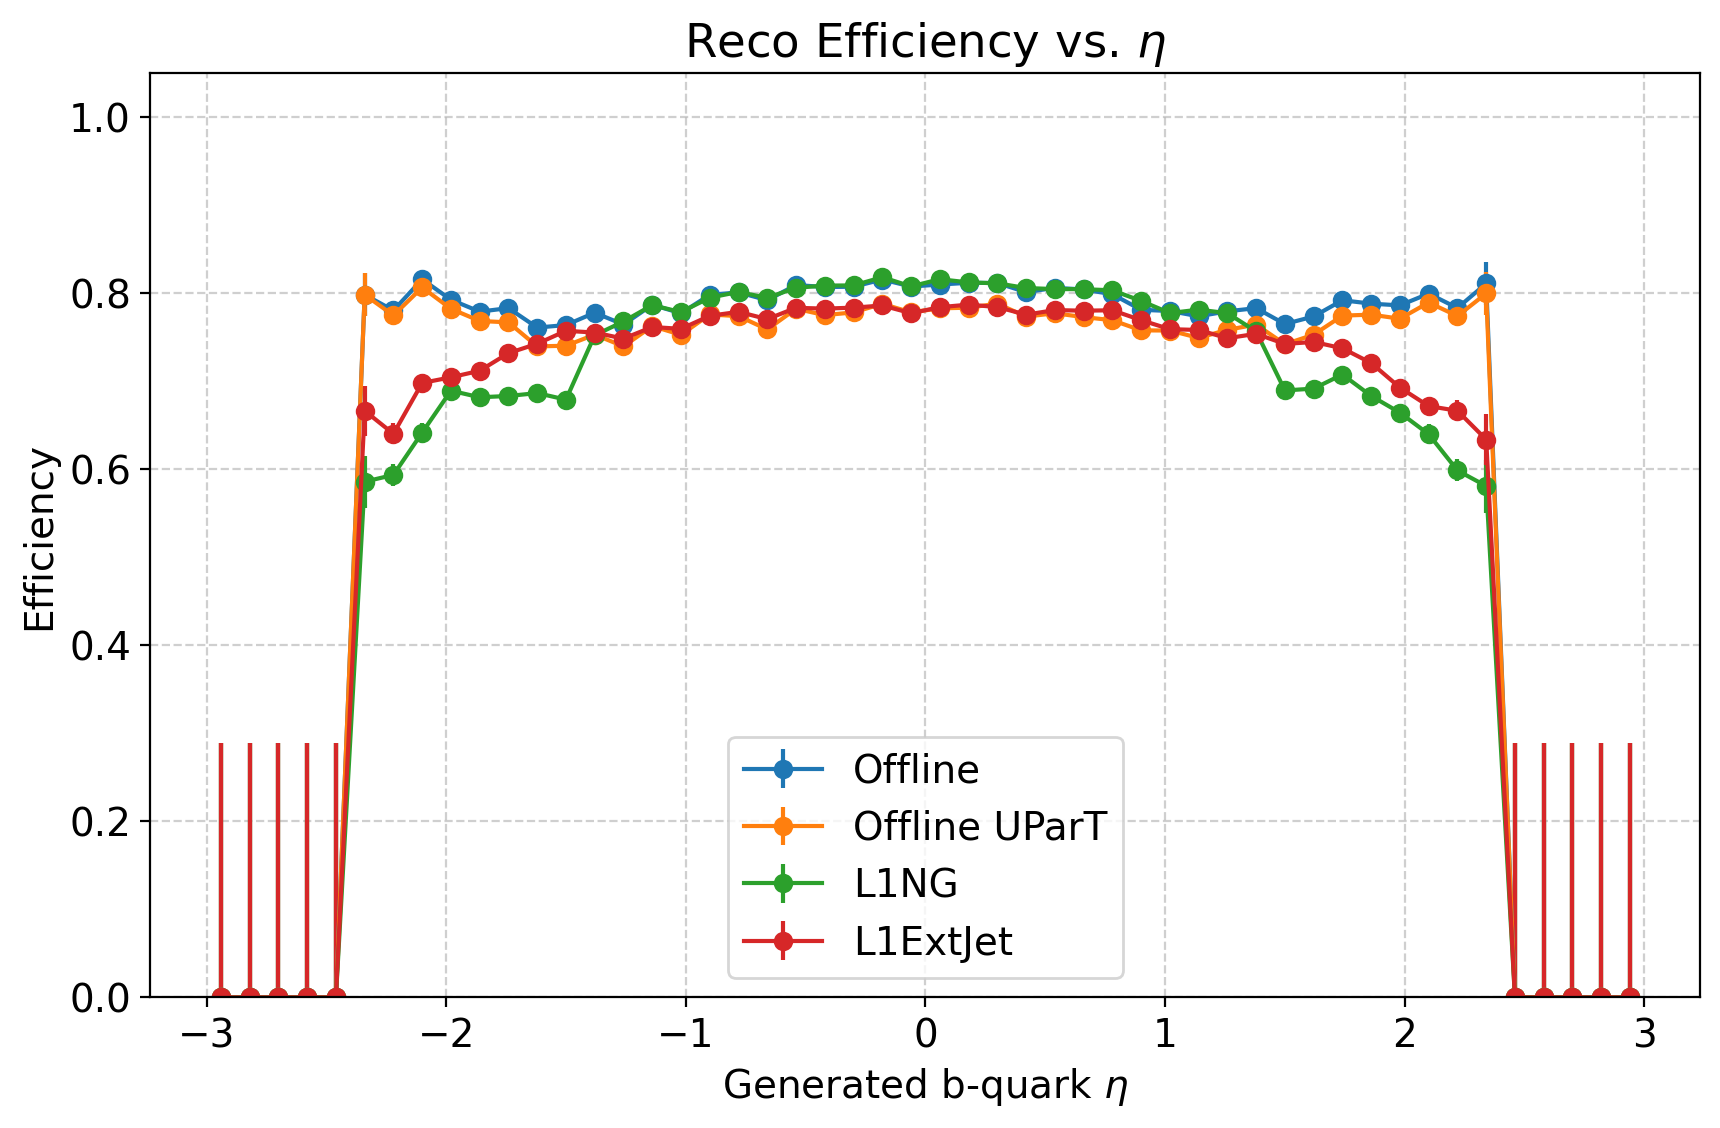

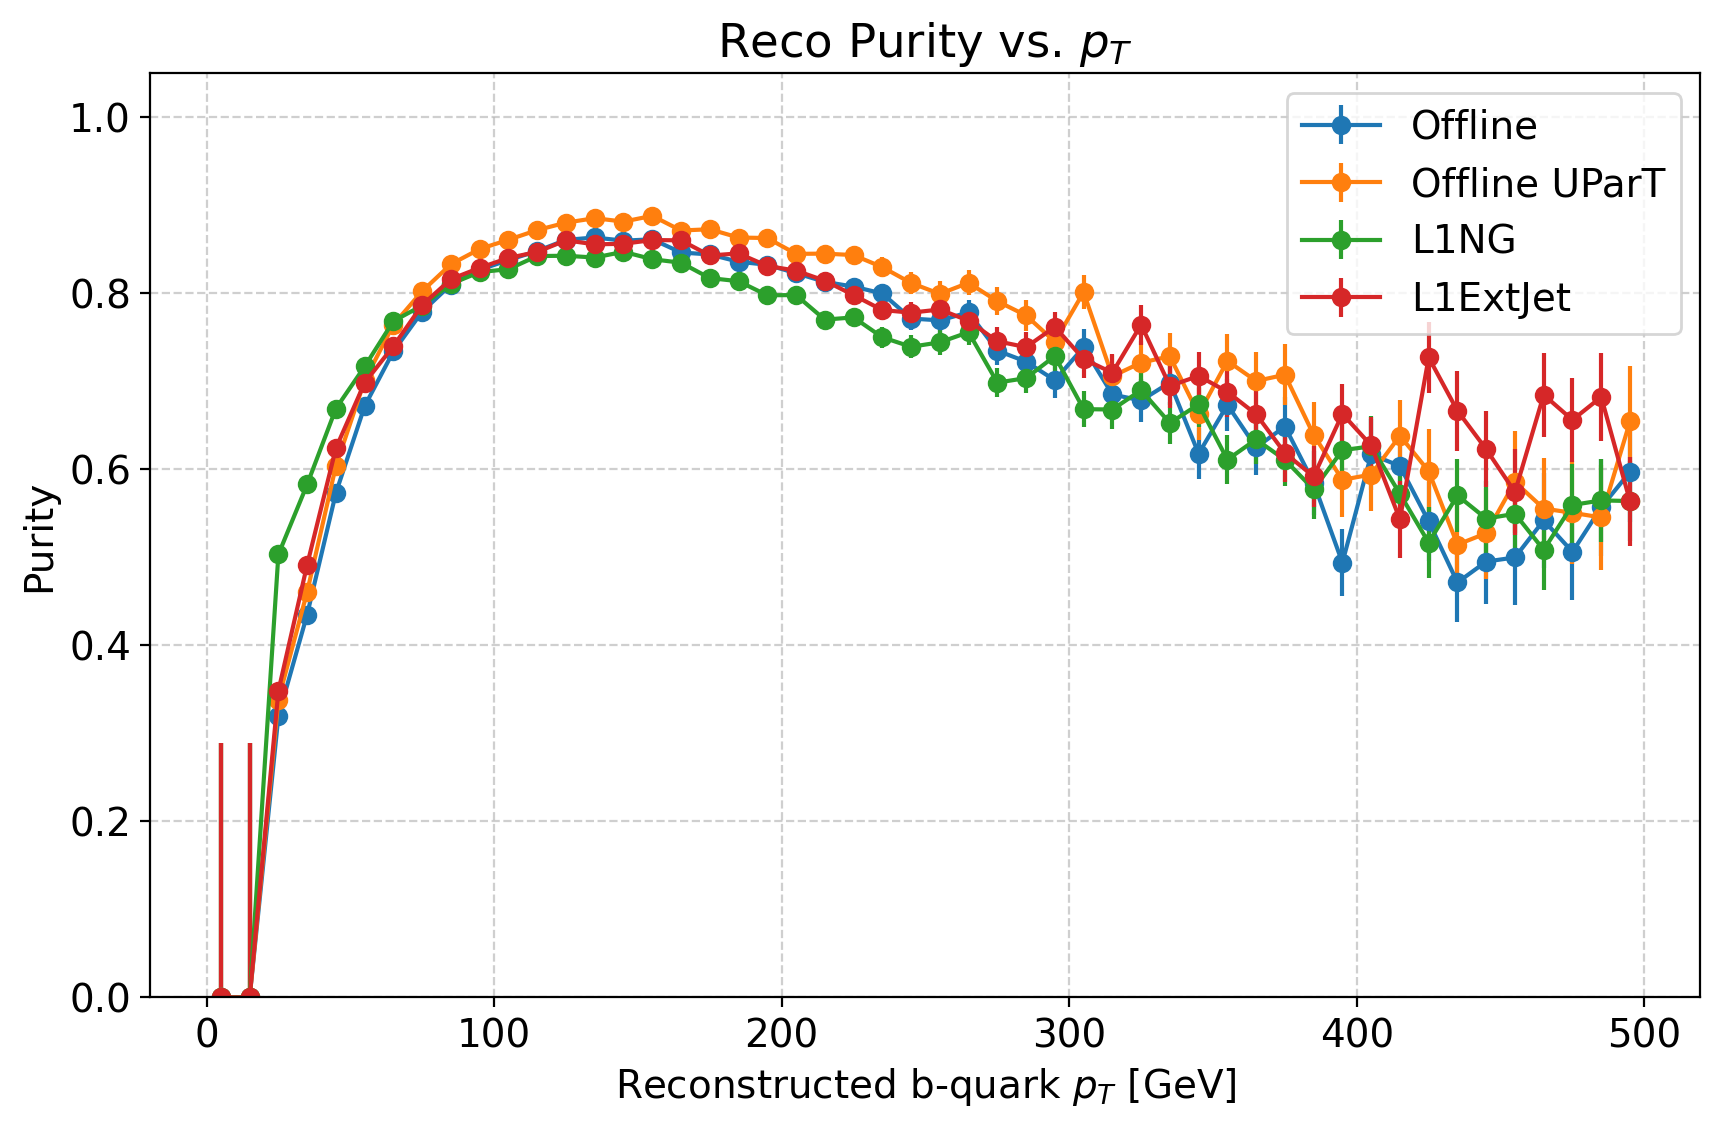

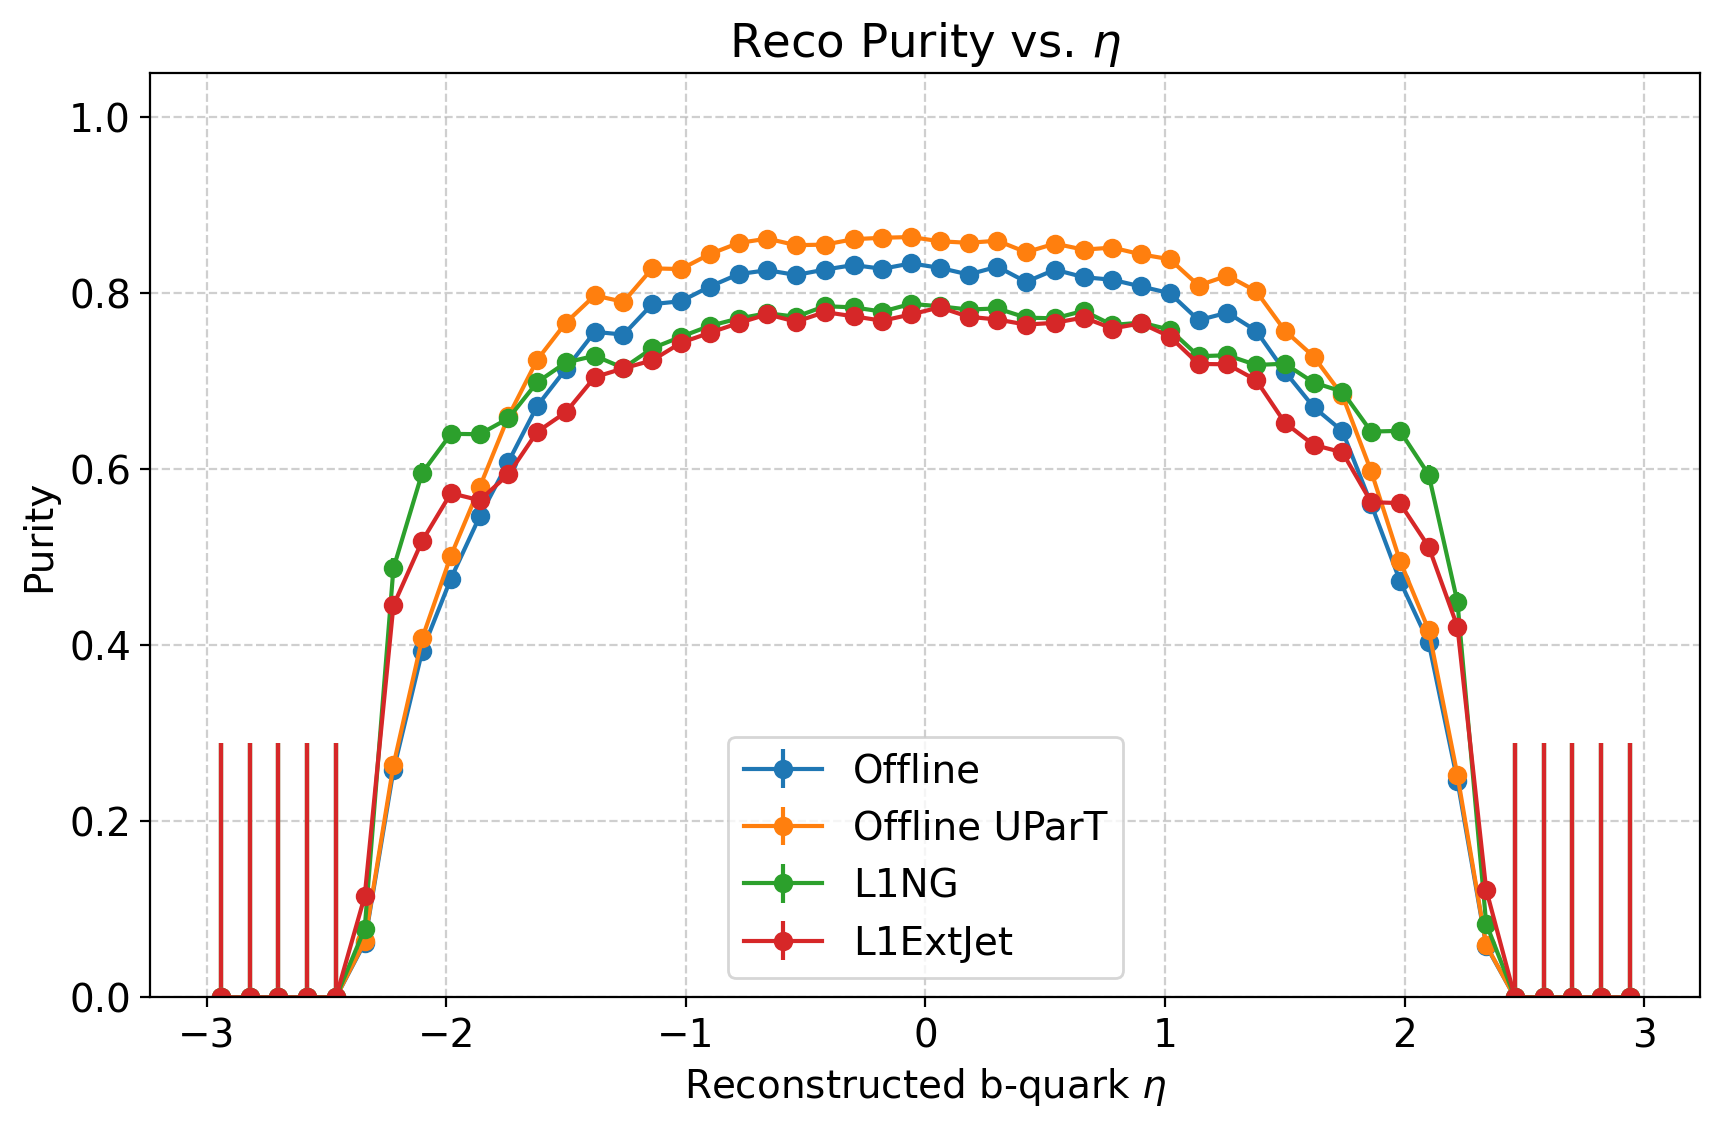

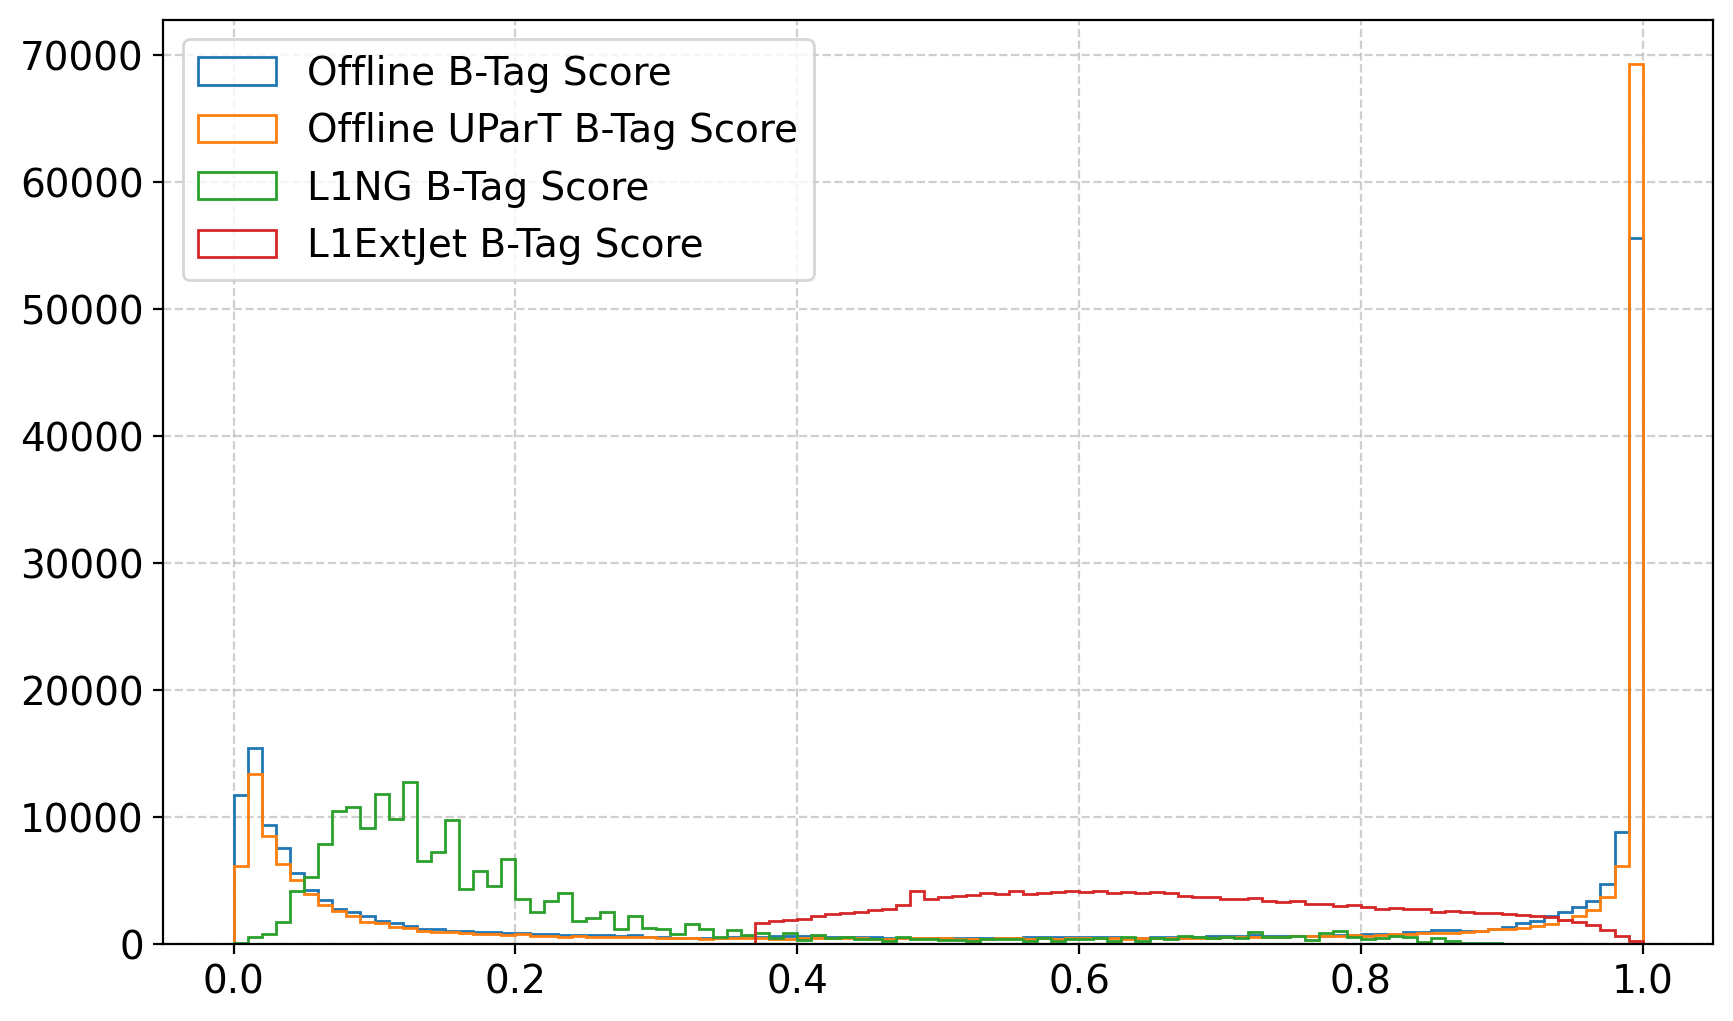


Applying custom pT cut of 25.0 GeV for offline jets...

Applying custom pT cut of 25.0 GeV for offline jets...

Applying custom pT cut of 25.0 GeV for l1ng jets...

Applying custom pT cut of 25.0 GeV for l1ext jets...


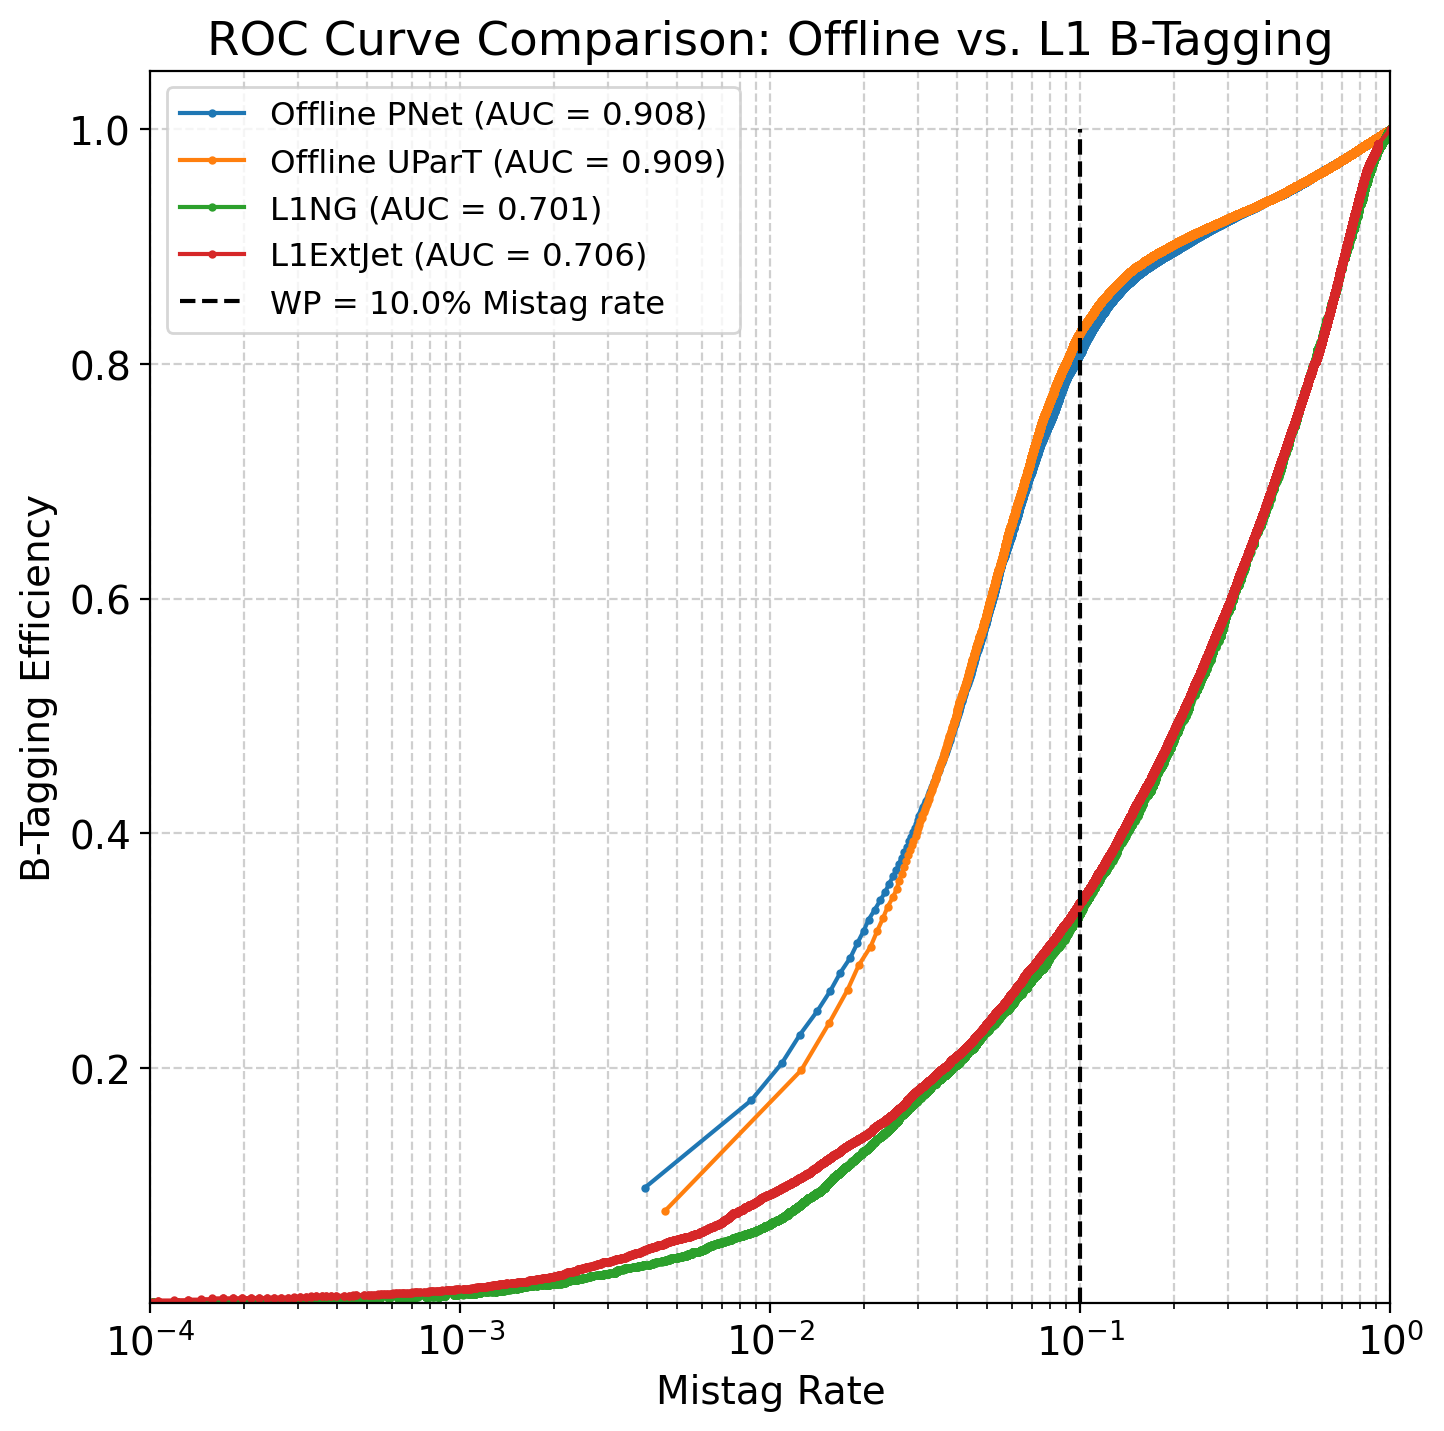


Offline 
AUC: 0.90777
Tight WP: TPR: 9.82713%, 1/FPR: 253.80000, Threshold: 0.00067
Medium WP: TPR: 20.41722%, 1/FPR: 91.89310, Threshold: 0.00080
Loose WP: TPR: 80.94546%, 1/FPR: 9.99462, Threshold: 0.00528

Offline UParT 
AUC: 0.90916
Tight WP: TPR: 7.82158%, 1/FPR: 219.03288, Threshold: 0.00035
Medium WP: TPR: 19.82828%, 1/FPR: 79.54925, Threshold: 0.00035
Loose WP: TPR: 82.76046%, 1/FPR: 9.99962, Threshold: 0.00496

L1 
AUC: 0.70117
Tight WP: TPR: 0.70696%, 1/FPR: 984.42000, Threshold: 0.02356
Medium WP: TPR: 6.69892%, 1/FPR: 99.83976, Threshold: 0.06007
Loose WP: TPR: 33.29539%, 1/FPR: 9.99411, Threshold: 0.22709

L1ExtJet 
AUC: 0.70627
Tight WP: TPR: 1.16334%, 1/FPR: 983.81818, Threshold: 0.01209
Medium WP: TPR: 9.25682%, 1/FPR: 99.93931, Threshold: 0.11274
Loose WP: TPR: 34.12712%, 1/FPR: 9.99789, Threshold: 0.37004


In [4]:
# for comparing the L1NG to the L1ExtJet, offline collections

import copy

with open("hh-bbbb-obj-config.json", "r") as config_file:
    CONFIG = json.load(config_file)

pt_bins = np.linspace(0, 500, 201)
eta_bins = np.linspace(-3, 3, 201)
b_tag_bins = np.linspace(0, 1, 101)

events = load_and_prepare_data(
    CONFIG["file_pattern"], 
    CONFIG["tree_name"], 
    [
        "GenPart", 
        CONFIG["offline"]["collection_name"], 
        CONFIG["l1ng"]["collection_name"],
        CONFIG["l1ext"]["collection_name"]
    ], 
    CONFIG["max_events"],
    correct_pt=True
)

upart_CONFIG = copy.deepcopy(CONFIG)
upart_CONFIG["offline"]["tagger_name"] = "btagUParTAK4B"
upart_CONFIG["offline"]["b_tag_cut"] = 0.00496  # loose WP

upart_events = load_and_prepare_data(
    upart_CONFIG["file_pattern"], 
    upart_CONFIG["tree_name"], 
    [
        upart_CONFIG["offline"]["collection_name"],
    ], 
    upart_CONFIG["max_events"],
    CONFIG=upart_CONFIG
)

gen_b_quarks = select_gen_b_quarks_from_higgs(events)
gen_b_quarks = gen_b_quarks[(gen_b_quarks.pt > CONFIG["gen"]["pt_cut"]) & (abs(gen_b_quarks.eta) < CONFIG["gen"]["eta_cut"])]

reco_jets_offline = apply_custom_cuts(events[CONFIG["offline"]["collection_name"]], CONFIG, "offline")
reco_jets_offline_upart = apply_custom_cuts(upart_events[upart_CONFIG["offline"]["collection_name"]], upart_CONFIG, "offline")
reco_jets_l1ng = apply_custom_cuts(events[CONFIG["l1ng"]["collection_name"]], CONFIG, "l1ng")
reco_jets_l1ext = apply_custom_cuts(events[CONFIG["l1ext"]["collection_name"]], CONFIG, "l1ext")

# efficiency masks
b_quarks_is_matched_offline = get_efficiency_mask(gen_b_quarks, reco_jets_offline)
b_quarks_is_matched_offline_upart = get_efficiency_mask(gen_b_quarks, reco_jets_offline_upart)
b_quarks_is_matched_l1ng = get_efficiency_mask(gen_b_quarks, reco_jets_l1ng)
b_quarks_is_matched_l1ext = get_efficiency_mask(gen_b_quarks, reco_jets_l1ext)
eff_objects = [
    ("Offline", reco_jets_offline, b_quarks_is_matched_offline),
    ("Offline UParT", reco_jets_offline_upart, b_quarks_is_matched_offline_upart),
    ("L1NG", reco_jets_l1ng, b_quarks_is_matched_l1ng),
    ("L1ExtJet", reco_jets_l1ext, b_quarks_is_matched_l1ext)
]

# purity masks
is_reco_jet_pure_offline = get_purity_mask_cross_matched(gen_b_quarks, reco_jets_offline)
is_reco_jet_pure_offline_upart = get_purity_mask_cross_matched(gen_b_quarks, reco_jets_offline_upart)
is_reco_jet_pure_l1ng = get_purity_mask_cross_matched(gen_b_quarks, reco_jets_l1ng)
is_reco_jet_pure_l1ext = get_purity_mask_cross_matched(gen_b_quarks, reco_jets_l1ext)
purity_objects = [
    ("Offline", reco_jets_offline, is_reco_jet_pure_offline),
    ("Offline UParT", reco_jets_offline_upart, is_reco_jet_pure_offline_upart),
    ("L1NG", reco_jets_l1ng, is_reco_jet_pure_l1ng),
    ("L1ExtJet", reco_jets_l1ext, is_reco_jet_pure_l1ext)
]

print("Plotting reconstruction efficiencies for L1NG vs L1ExtJet...")
plot_kinematic_comparison(
    bins=np.linspace(0, 500, 51), variable="pt",
    xlabel=r"Generated b-quark $p_T$ [GeV]", title="Reco Efficiency vs. $p_T$",
    gen_particles=gen_b_quarks,
    objects=eff_objects
)
plot_kinematic_comparison(
    bins=np.linspace(-3, 3, 51), variable="eta",
    xlabel="Generated b-quark $\\eta$", title="Reco Efficiency vs. $\\eta$",
    gen_particles=gen_b_quarks,
    objects=eff_objects
)

plot_kinematic_comparison(
    bins=np.linspace(0, 500, 51), variable="pt",
    xlabel=r"Reconstructed b-quark $p_T$ [GeV]", title="Reco Purity vs. $p_T$",
    gen_particles=gen_b_quarks,
    objects=purity_objects,
    is_purity_plot=True
)
plot_kinematic_comparison(
    bins=np.linspace(-3, 3, 51), variable="eta",
    xlabel="Reconstructed b-quark $\\eta$", title="Reco Purity vs. $\\eta$",
    gen_particles=gen_b_quarks,
    objects=purity_objects,
    is_purity_plot=True
)


# plot_btag_map(reco_jets_l1ext, "btagScore", pt_bins, eta_bins)
# plot_btag_map(reco_jets_offline, CONFIG["offline"]["tagger_name"], pt_bins, eta_bins)
# plot_btag_map(reco_jets_offline_upart, "btagUParTAK4B", pt_bins, eta_bins)
# plot_btag_map(reco_jets_l1ng, CONFIG["l1ng"]["tagger_name"], pt_bins, eta_bins)

plt.hist(ak.flatten(getattr(reco_jets_offline, CONFIG["offline"]["tagger_name"])), bins=b_tag_bins, histtype="step", label="Offline B-Tag Score")
plt.hist(ak.flatten(getattr(reco_jets_offline_upart, "btagUParTAK4B")), bins=b_tag_bins, histtype="step", label="Offline UParT B-Tag Score")
plt.hist(ak.flatten(getattr(reco_jets_l1ng, CONFIG["l1ng"]["tagger_name"])), bins=b_tag_bins, histtype="step", label="L1NG B-Tag Score")
plt.hist(ak.flatten(getattr(reco_jets_l1ext, CONFIG["l1ext"]["tagger_name"])), bins=b_tag_bins, histtype="step", label="L1ExtJet B-Tag Score")
plt.legend()
plt.show()

# plot_signal_background_histogram(reco_jets_offline, is_reco_jet_pure_offline, pt_bins, "pt", r"Offline Jet $p_T$ [GeV]", "Offline Jet $p_T$ Distribution")
# plot_signal_background_histogram(reco_jets_offline_upart, is_reco_jet_pure_offline_upart, pt_bins, "pt", r"Offline UParT Jet $p_T$ [GeV]", "Offline UParT Jet $p_T$ Distribution")
# plot_signal_background_histogram(reco_jets_l1ng, is_reco_jet_pure_l1ng, pt_bins, "pt", r"L1NG Jet $p_T$ [GeV]", "L1NG Jet $p_T$ Distribution")
# plot_signal_background_histogram(reco_jets_l1ext, is_reco_jet_pure_l1ext, pt_bins, "pt", r"L1ExtJet Jet $p_T$ [GeV]", "L1ExtJet Jet $p_T$ Distribution")

# plot_signal_background_histogram(reco_jets_offline, is_reco_jet_pure_offline, np.linspace(-3, 3, 51), "eta", "Offline Jet $\\eta$", "Offline Jet $\\eta$ Distribution")
# plot_signal_background_histogram(reco_jets_offline_upart, is_reco_jet_pure_offline_upart, np.linspace(-3, 3, 51), "eta", "Offline UParT Jet $\\eta$", "Offline UParT Jet $\\eta$ Distribution")
# plot_signal_background_histogram(reco_jets_l1ng, is_reco_jet_pure_l1ng, np.linspace(-3, 3, 51), "eta", "L1NG Jet $\\eta$", "L1NG Jet $\\eta$ Distribution")
# plot_signal_background_histogram(reco_jets_l1ext, is_reco_jet_pure_l1ext, np.linspace(-3, 3, 51), "eta", "L1ExtJet Jet $\\eta$", "L1ExtJet Jet $\\eta$ Distribution")

# plot_signal_background_histogram(reco_jets_offline, is_reco_jet_pure_offline, np.linspace(0, 1, 51), CONFIG["offline"]["tagger_name"], "Offline Jet B-Tag Score", "Offline Jet B-Tag Score Distribution")
# plot_signal_background_histogram(reco_jets_offline_upart, is_reco_jet_pure_offline_upart, np.linspace(0, 1, 51), "btagUParTAK4B", "Offline UParT Jet B-Tag Score", "Offline UParT Jet B-Tag Score Distribution")
# plot_signal_background_histogram(reco_jets_l1ng, is_reco_jet_pure_l1ng, np.linspace(0, 1, 51), CONFIG["l1ng"]["tagger_name"], "L1NG Jet B-Tag Score", "L1NG Jet B-Tag Score Distribution")
# plot_signal_background_histogram(reco_jets_l1ext, is_reco_jet_pure_l1ext, np.linspace(0, 1, 51), CONFIG["l1ext"]["tagger_name"], "L1ExtJet Jet B-Tag Score", "L1ExtJet Jet B-Tag Score Distribution")

offline_roc_events = apply_custom_cuts(events[CONFIG["offline"]["collection_name"]], CONFIG, "offline", kinematic_only=True)
offline_upart_roc_events = apply_custom_cuts(upart_events[upart_CONFIG["offline"]["collection_name"]], upart_CONFIG, "offline", kinematic_only=True)
l1ng_roc_events = apply_custom_cuts(events[CONFIG["l1ng"]["collection_name"]], CONFIG, "l1ng", kinematic_only=True)
l1ext_roc_events = apply_custom_cuts(events[CONFIG["l1ext"]["collection_name"]], CONFIG, "l1ext", kinematic_only=True)

offline_roc_mask = get_purity_mask_cross_matched(gen_b_quarks, offline_roc_events)
offline_upart_roc_mask = get_purity_mask_cross_matched(gen_b_quarks, offline_upart_roc_events)
l1ng_roc_mask = get_purity_mask_cross_matched(gen_b_quarks, l1ng_roc_events)
l1ext_roc_mask = get_purity_mask_cross_matched(gen_b_quarks, l1ext_roc_events)

offline_roc = calculate_roc_points(
    offline_roc_events, 
    offline_roc_mask, 
    CONFIG["offline"]["tagger_name"]
)

offline_upart_roc = calculate_roc_points(
    offline_upart_roc_events, 
    offline_upart_roc_mask, 
    "btagUParTAK4B"
)

l1ng_roc = calculate_roc_points(
    l1ng_roc_events, 
    l1ng_roc_mask, 
    CONFIG["l1ng"]["tagger_name"]
)
l1ext_roc = calculate_roc_points(
    l1ext_roc_events, 
    l1ext_roc_mask, 
    CONFIG["l1ext"]["tagger_name"]
)

plot_roc_comparison([
    (f"Offline PNet", offline_roc),
    (f"Offline UParT", offline_upart_roc),
    ("L1NG", l1ng_roc),
    ("L1ExtJet", l1ext_roc)
    ],
    working_point=0.1
)


mistag_offline, eff_offline, auc_offline, thresh_offline = offline_roc
mistag_offline_upart, eff_offline_upart, auc_offline_upart, thresh_offline_upart = offline_upart_roc
mistag_l1, eff_l1, auc_l1, thresh_l1 = l1ng_roc
mistag_l1ext, eff_l1ext, auc_l1ext, thresh_l1ext = l1ext_roc

def get_roc_point_at_efficiency(mistag, eff, thresh, target_eff):
    thresh = np.sort(thresh)
    return [(m, e, th) for m, e, th in zip(mistag, eff, thresh) if e >= target_eff][0]

def get_roc_point_at_mistag(mistag, eff, thresh, target_mistag):
    thresh = np.sort(thresh)
    return [(m, e, th) for m, e, th in zip(mistag, eff, thresh) if m >= target_mistag][0]

fpr_offline_tight, tpr_offline_tight, thresh_offline_tight = get_roc_point_at_mistag(mistag_offline, eff_offline, thresh_offline, 0.001)
fpr_offline_medium, tpr_offline_medium, thresh_offline_medium = get_roc_point_at_mistag(mistag_offline, eff_offline, thresh_offline, 0.01)
fpr_offline_loose, tpr_offline_loose, thresh_offline_loose = get_roc_point_at_mistag(mistag_offline, eff_offline, thresh_offline, 0.1)
print(f"\nOffline \nAUC: {auc_offline:.5f}")
print(f"Tight WP: TPR: {tpr_offline_tight * 100:.5f}%, 1/FPR: {1/fpr_offline_tight:.5f}, Threshold: {thresh_offline_tight:.5f}")
print(f"Medium WP: TPR: {tpr_offline_medium * 100:.5f}%, 1/FPR: {1/fpr_offline_medium:.5f}, Threshold: {thresh_offline_medium:.5f}")
print(f"Loose WP: TPR: {tpr_offline_loose * 100:.5f}%, 1/FPR: {1/fpr_offline_loose:.5f}, Threshold: {thresh_offline_loose:.5f}")

fpr_offline_upart_tight, tpr_offline_upart_tight, thresh_offline_upart_tight = get_roc_point_at_mistag(mistag_offline_upart, eff_offline_upart, thresh_offline_upart, 0.001)
fpr_offline_upart_medium, tpr_offline_upart_medium, thresh_offline_upart_medium = get_roc_point_at_mistag(mistag_offline_upart, eff_offline_upart, thresh_offline_upart, 0.01)
fpr_offline_upart_loose, tpr_offline_upart_loose, thresh_offline_upart_loose = get_roc_point_at_mistag(mistag_offline_upart, eff_offline_upart, thresh_offline_upart, 0.1)
print(f"\nOffline UParT \nAUC: {auc_offline_upart:.5f}")
print(f"Tight WP: TPR: {tpr_offline_upart_tight * 100:.5f}%, 1/FPR: {1/fpr_offline_upart_tight:.5f}, Threshold: {thresh_offline_upart_tight:.5f}")
print(f"Medium WP: TPR: {tpr_offline_upart_medium * 100:.5f}%, 1/FPR: {1/fpr_offline_upart_medium:.5f}, Threshold: {thresh_offline_upart_medium:.5f}")
print(f"Loose WP: TPR: {tpr_offline_upart_loose * 100:.5f}%, 1/FPR: {1/fpr_offline_upart_loose:.5f}, Threshold: {thresh_offline_upart_loose:.5f}")


fpr_l1_tight, tpr_l1_tight, thresh_l1_tight = get_roc_point_at_mistag(mistag_l1, eff_l1, thresh_l1, 0.001)
fpr_l1_medium, tpr_l1_medium, thresh_l1_medium = get_roc_point_at_mistag(mistag_l1, eff_l1, thresh_l1, 0.01)
fpr_l1_loose, tpr_l1_loose, thresh_l1_loose = get_roc_point_at_mistag(mistag_l1, eff_l1, thresh_l1, 0.1)
print(f"\nL1 \nAUC: {auc_l1:.5f}")
print(f"Tight WP: TPR: {tpr_l1_tight * 100:.5f}%, 1/FPR: {1/fpr_l1_tight:.5f}, Threshold: {thresh_l1_tight:.5f}")
print(f"Medium WP: TPR: {tpr_l1_medium * 100:.5f}%, 1/FPR: {1/fpr_l1_medium:.5f}, Threshold: {thresh_l1_medium:.5f}")
print(f"Loose WP: TPR: {tpr_l1_loose * 100:.5f}%, 1/FPR: {1/fpr_l1_loose:.5f}, Threshold: {thresh_l1_loose:.5f}")

fpr_l1ext_tight, tpr_l1ext_tight, thresh_l1ext_tight = get_roc_point_at_mistag(mistag_l1ext, eff_l1ext, thresh_l1ext, 0.001)
fpr_l1ext_medium, tpr_l1ext_medium, thresh_l1ext_medium = get_roc_point_at_mistag(mistag_l1ext, eff_l1ext, thresh_l1ext, 0.01)
fpr_l1ext_loose, tpr_l1ext_loose, thresh_l1ext_loose = get_roc_point_at_mistag(mistag_l1ext, eff_l1ext, thresh_l1ext, 0.1)
print(f"\nL1ExtJet \nAUC: {auc_l1ext:.5f}")
print(f"Tight WP: TPR: {tpr_l1ext_tight * 100:.5f}%, 1/FPR: {1/fpr_l1ext_tight:.5f}, Threshold: {thresh_l1ext_tight:.5f}")
print(f"Medium WP: TPR: {tpr_l1ext_medium * 100:.5f}%, 1/FPR: {1/fpr_l1ext_medium:.5f}, Threshold: {thresh_l1ext_medium:.5f}")
print(f"Loose WP: TPR: {tpr_l1ext_loose * 100:.5f}%, 1/FPR: {1/fpr_l1ext_loose:.5f}, Threshold: {thresh_l1ext_loose:.5f}")

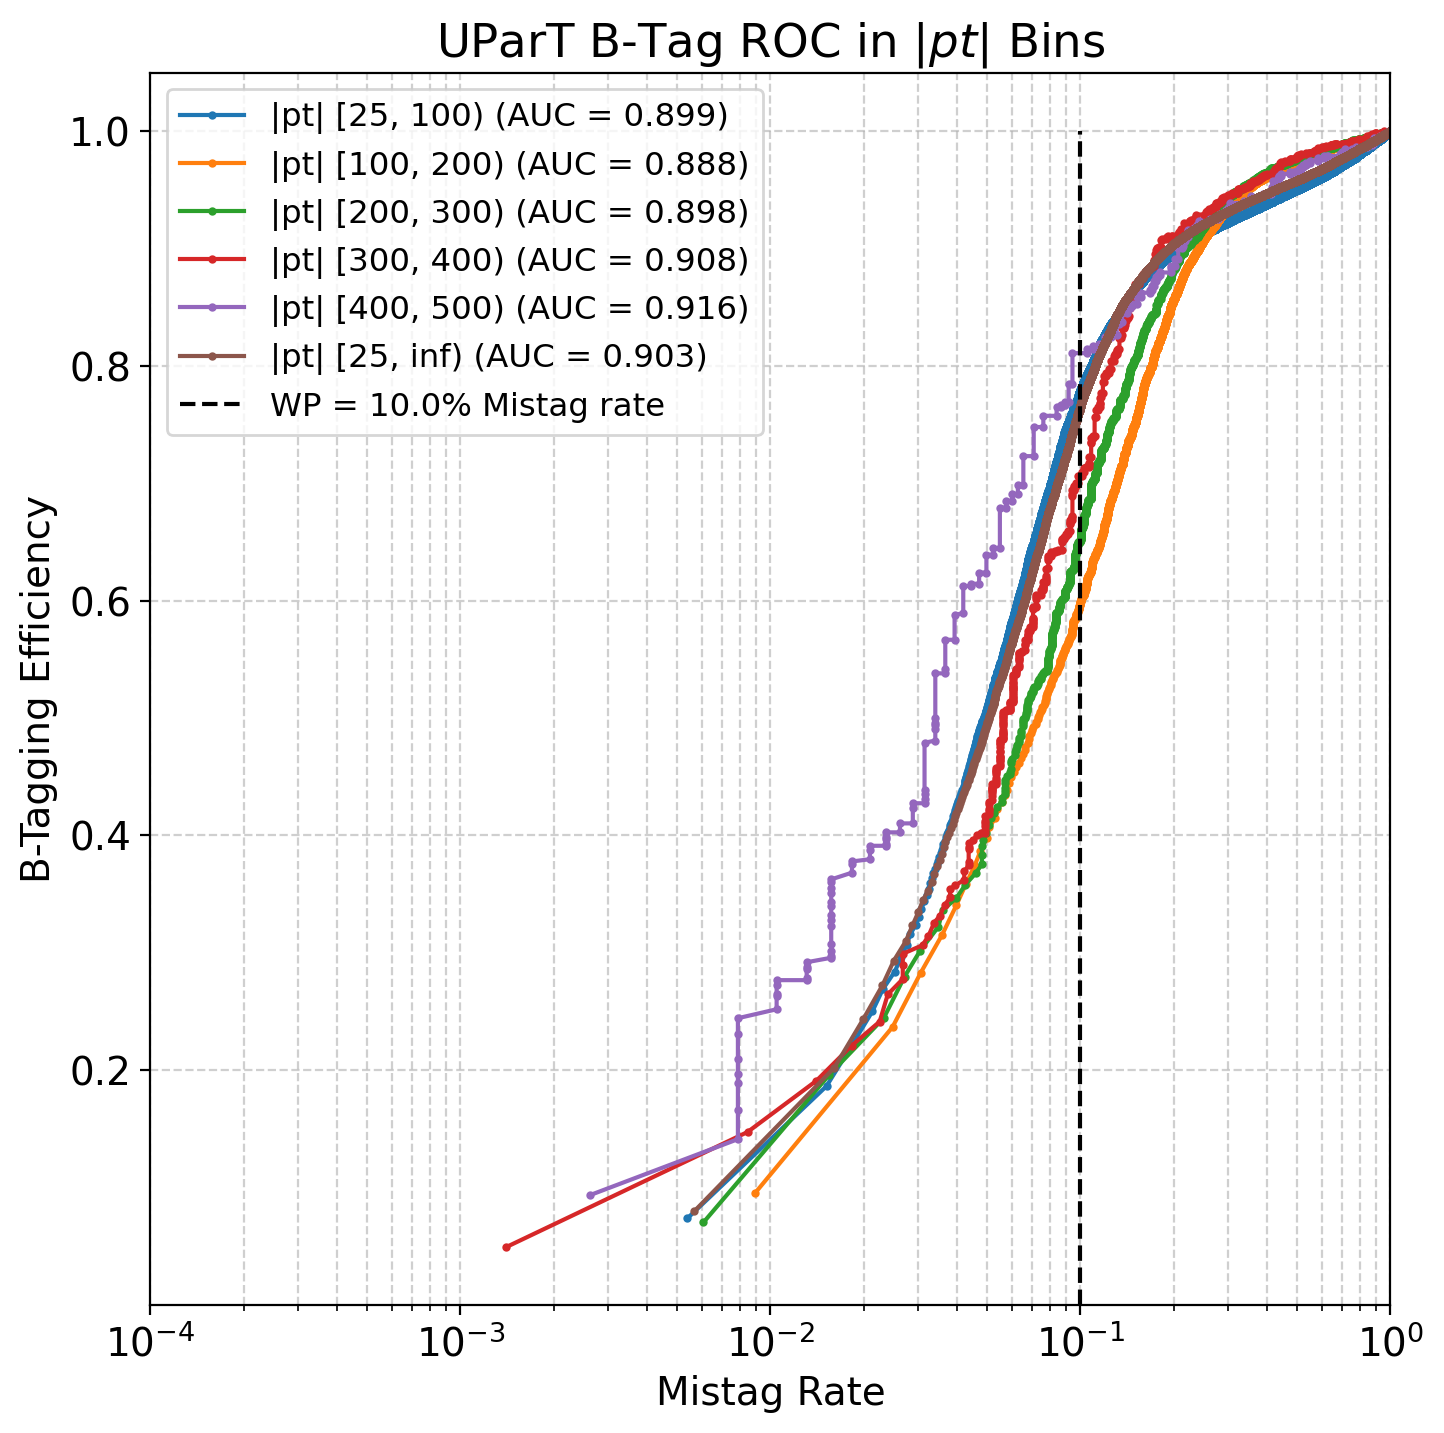

In [14]:
pt_ranges = [(25, 100), (100, 200), (200, 300), (300, 400), (400, 500), (25, np.inf)]
eta_ranges = [(0, 1.5), (1.5, 2.0), (2.0, 2.4), (0, 2.4)]

collection_label = "UParT"
reco_jets = reco_jets_offline_upart
tagger_name = upart_CONFIG["offline"]["tagger_name"]
var = "pt"
var_ranges = pt_ranges

def calculate_btag_roc_in_bins(gen_b_quarks, reco_jets, tagger_name, var, var_ranges):
    """
    Calculate b-tagging ROC curves in bins of a given variable.
    Parameters
    ----------
    gen_b_quarks : awkward.Array
        Generated b-quarks.
    reco_jets : awkward.Array
        Reconstructed jets.
    tagger_name : str
        Name of the b-tagging discriminator.
    var : str
        Variable to bin in (e.g., "pt" or "eta").
    var_ranges : list of tuple
        List of (min, max) tuples defining the bins for the variable.
    Returns
    -------
    dict
        Dictionary mapping bin labels to ROC curve points.
    """
    rocs = {}
    for var_min, var_max in var_ranges:
        var_mask = (abs(getattr(reco_jets, var)) >= var_min) & (abs(getattr(reco_jets, var)) < var_max)
        reco_jets_var_bin = reco_jets[var_mask]
        if len(reco_jets_var_bin) == 0:
            print(f"No jets found in {var} bin [{var_min}, {var_max}), skipping ROC calculation.")
            continue
        roc_points = calculate_roc_points(
            reco_jets_var_bin, 
            get_purity_mask_cross_matched(gen_b_quarks, reco_jets_var_bin), 
            tagger_name
        )
        rocs[f"{var}_{var_min}_{var_max}"] = roc_points

    return rocs
    
rocs = calculate_btag_roc_in_bins(
    gen_b_quarks, reco_jets, tagger_name, var, var_ranges
)
plot_roc_comparison(
    [(f"|{var}| [{var_min}, {var_max})", rocs[f"{var}_{var_min}_{var_max}"]) for var_min, var_max in var_ranges],
    working_point=0.1,
    title=rf"{collection_label} B-Tag ROC in |${var}$| Bins"
)

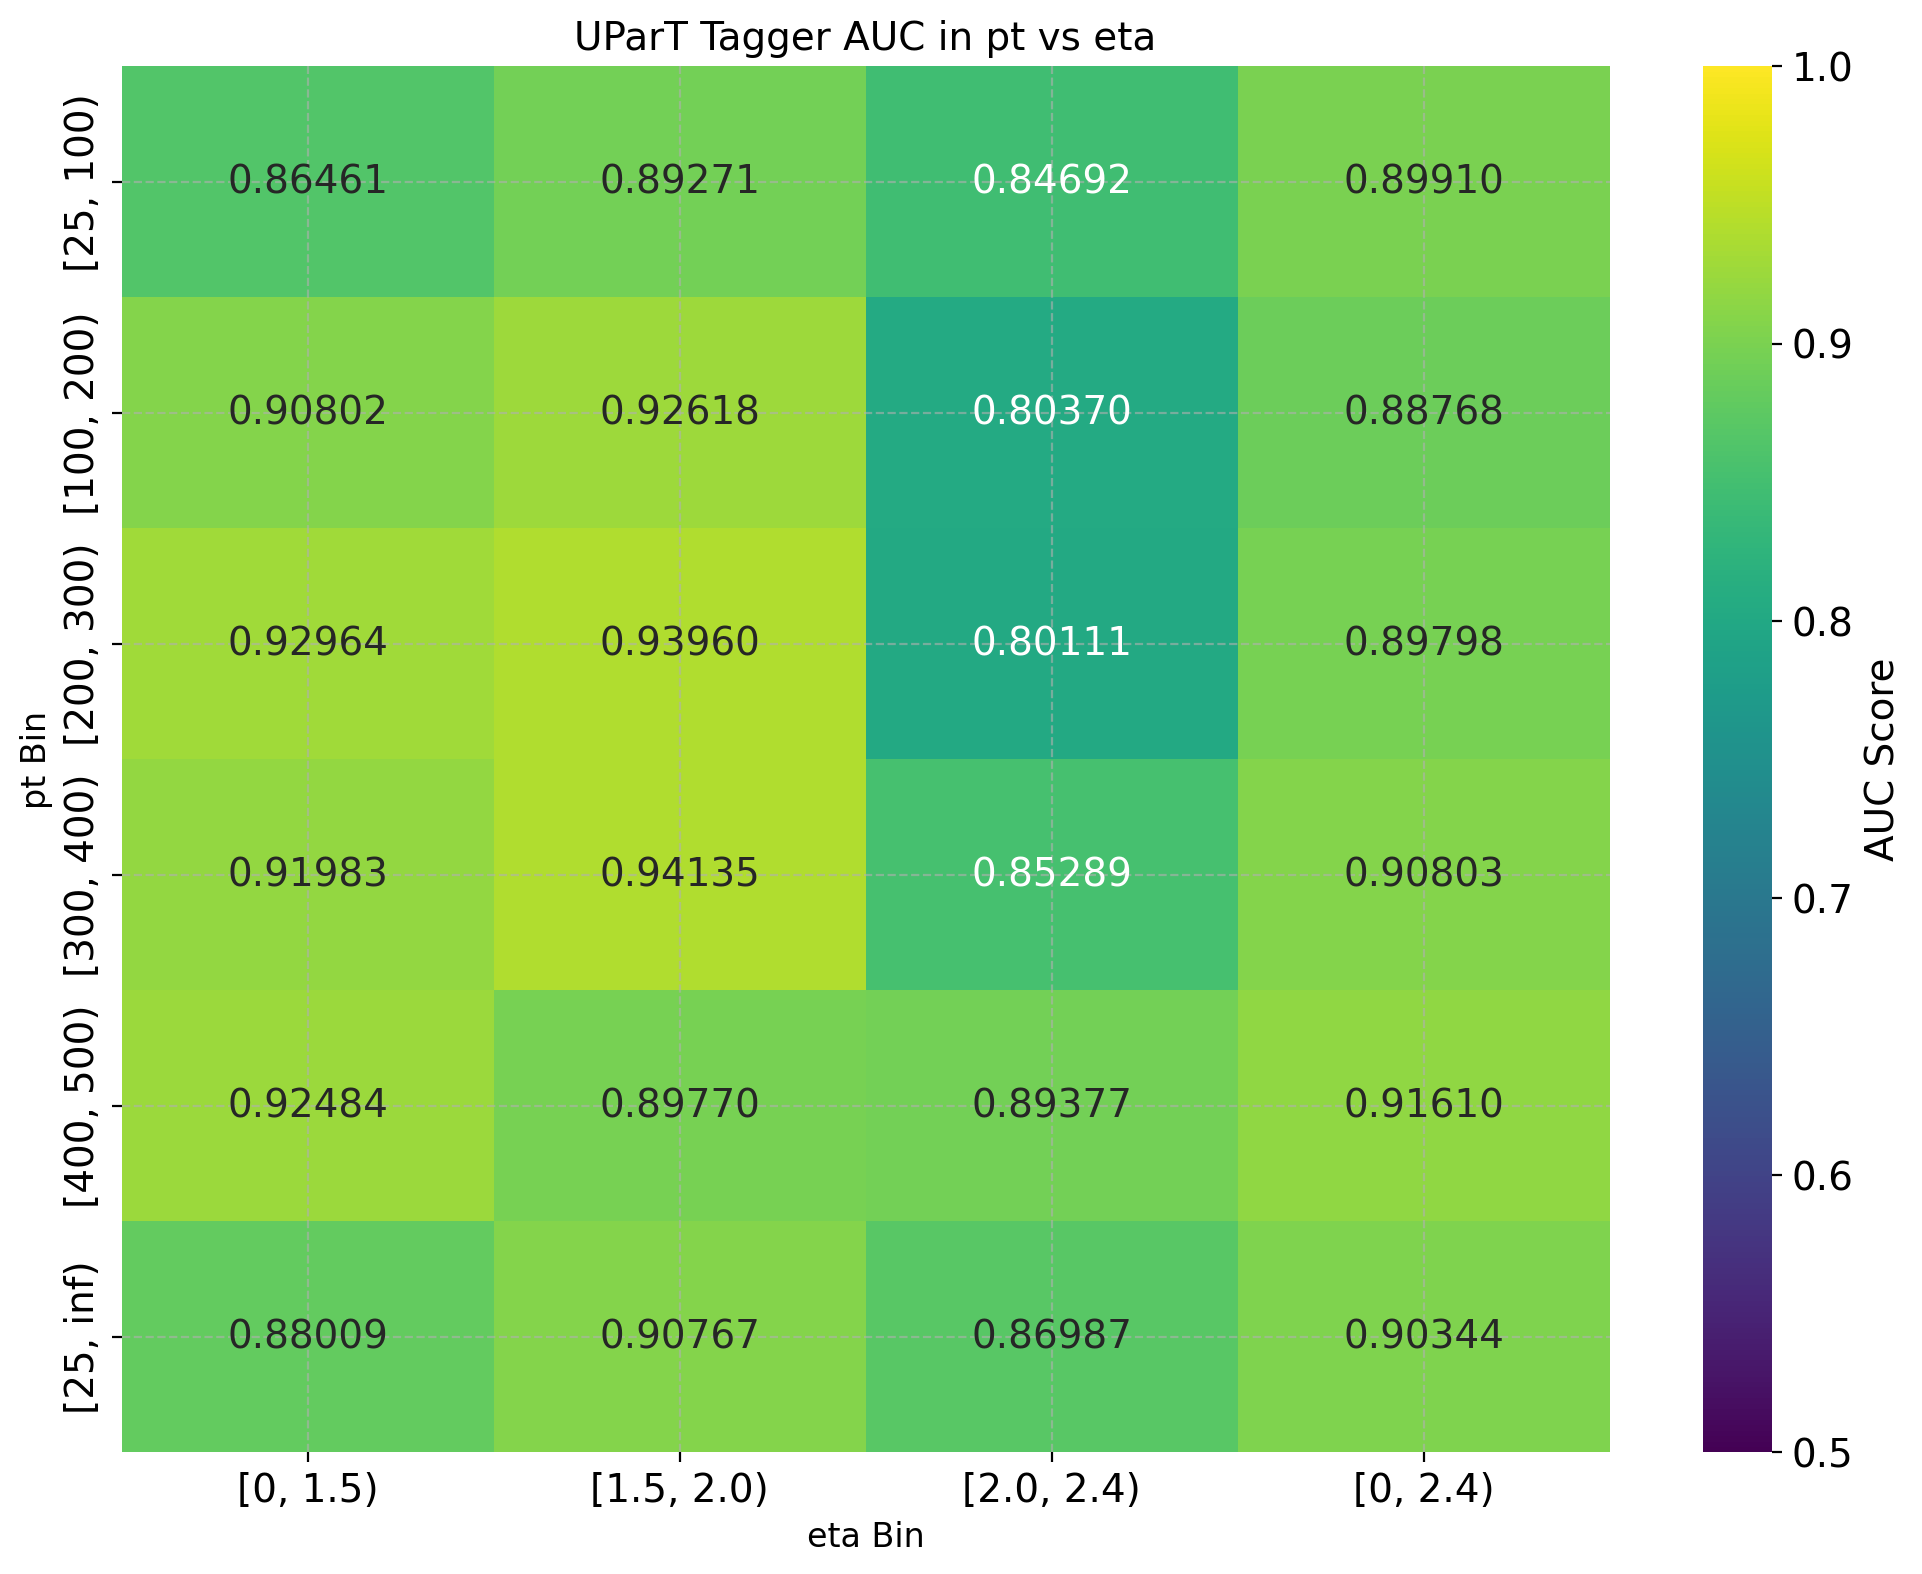

In [15]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def calculate_btag_roc_2d_bins(gen_b_quarks, reco_jets, tagger_name, var1, var1_ranges, var2, var2_ranges):
    """
    Calculate b-tagging ROC curves in 2D bins (e.g., pt AND eta).
    """
    rocs = {}
    
    for v1_min, v1_max in var1_ranges:
        for v2_min, v2_max in var2_ranges:
            # Create a combined mask for both variables
            mask1 = (abs(getattr(reco_jets, var1)) >= v1_min) & (abs(getattr(reco_jets, var1)) < v1_max)
            mask2 = (abs(getattr(reco_jets, var2)) >= v2_min) & (abs(getattr(reco_jets, var2)) < v2_max)
            combined_mask = mask1 & mask2
            
            reco_jets_bin = reco_jets[combined_mask]
            
            bin_label = f"{var1}_{v1_min}_{v1_max}_{var2}_{v2_min}_{v2_max}"
            
            if len(reco_jets_bin) == 0:
                print(f"No jets found in bin {bin_label}, skipping.")
                continue
                
            # Reuse your existing calculate_roc_points function
            roc_points = calculate_roc_points(
                reco_jets_bin, 
                get_purity_mask_cross_matched(gen_b_quarks, reco_jets_bin), 
                tagger_name
            )
            rocs[bin_label] = roc_points

    return rocs

# --- Execution ---
var1, var1_ranges = "pt", pt_ranges # Simplified for readability
var2, var2_ranges = "eta", eta_ranges

rocs_2d = calculate_btag_roc_2d_bins(
    gen_b_quarks, reco_jets, tagger_name, var1, var1_ranges, var2, var2_ranges
)

# --- Plotting ---
# Note: Plotting 10+ lines on one ROC plot gets messy. 
# You might want to filter which bins you pass to plot_roc_comparison.
# plot_list = []
# for key, data in rocs_2d.items():
#     # Format label for the legend
#     label = key.replace("_", " ") 
#     plot_list.append((label, data))

# plot_roc_comparison(
#     plot_list,
#     working_point=0.1,
#     title=f"L1 B-Tag ROC: {var1} vs {var2} Bins"
# )

def get_mistag_at_fixed_eff(fpr, tpr, target_eff=0.7):
    """
    Returns the Mistag Rate (FPR) at a specific fixed Efficiency (TPR).
    """
    # np.interp requires the x-coordinates (tpr) to be increasing.
    if not np.all(np.diff(tpr) >= 0):
        # Sort by TPR if not sorted
        sorted_indices = np.argsort(tpr)
        tpr = tpr[sorted_indices]
        fpr = fpr[sorted_indices]
        
    return np.interp(target_eff, tpr, fpr)

def plot_2d_performance_heatmap(rocs_2d, var1, var1_ranges, var2, var2_ranges, 
                                metric="mistag", target_eff=0.1, collection_label="PNet", min_val=None, max_val=None):
    """
    Plots a heatmap of a specific metric across 2D bins.
    
    Parameters
    ----------
    metric : str
        "auc" for Area Under Curve
        "mistag" for Mistag Rate at fixed efficiency
    target_eff : float
        The fixed efficiency point (only used if metric="mistag")
    """
    matrix = np.zeros((len(var1_ranges), len(var2_ranges)))
    
    cbar_label = ""
    title_text = f"{collection_label} "
    
    if metric == "auc":
        cbar_label = "AUC Score"
        title_text += f"Tagger AUC in {var1} vs {var2}"
    elif metric == "mistag":
        cbar_label = f"Mistag Rate @ {target_eff*100:.0f}% Eff"
        title_text += f"Mistag Rate (at {target_eff*100:.0f}% Eff) in {var1} vs {var2}"
    
    for i, (v1_min, v1_max) in enumerate(var1_ranges):
        for j, (v2_min, v2_max) in enumerate(var2_ranges):
            bin_label = f"{var1}_{v1_min}_{v1_max}_{var2}_{v2_min}_{v2_max}"
            
            if bin_label in rocs_2d:
                fpr, tpr, auc_val, thresholds = rocs_2d[bin_label]
                
                if metric == "auc":
                    matrix[i, j] = auc_val
                elif metric == "mistag":
                    matrix[i, j] = get_mistag_at_fixed_eff(fpr, tpr, target_eff)
            else:
                matrix[i, j] = np.nan

    df = pd.DataFrame(
        matrix, 
        index=[f"[{low}, {high})" for low, high in var1_ranges],
        columns=[f"[{low}, {high})" for low, high in var2_ranges]
    )

    # Plotting
    plt.figure(figsize=(12, 9))
    
    # Use a different colormap for Mistag (lower is better) vs AUC (higher is better)
    cmap = "viridis" if metric == "auc" else "magma_r" 
    
    ax = sns.heatmap(df, annot=True, fmt=".5f", cmap=cmap, cbar_kws={'label': cbar_label}, vmin=min_val, vmax=max_val)
    
    plt.title(title_text, fontsize=14)
    plt.xlabel(f"{var2} Bin", fontsize=12)
    plt.ylabel(f"{var1} Bin", fontsize=12)
    plt.show()
# Execution
plot_2d_performance_heatmap(rocs_2d, "pt", var1_ranges, "eta", var2_ranges, metric="auc", target_eff=0.1, collection_label=collection_label, min_val=0.5, max_val=1.0)

In [ ]:
def plot_roc_grid(rocs_2d, var1, var1_ranges, var2, var2_ranges, collection_label="PNet"):
    """
    Plots a grid of ROC curves. Each subplot is a pT bin, 
    with different colored lines for Eta bins.
    """
    fig, axes = plt.subplots(1, len(var1_ranges), figsize=(5 * len(var1_ranges), 5), sharey=True)
    
    if len(var1_ranges) == 1: axes = [axes] # Handle single row case

    for i, (v1_min, v1_max) in enumerate(var1_ranges):
        ax = axes[i]
        for v2_min, v2_max in var2_ranges:
            bin_label = f"{var1}_{v1_min}_{v1_max}_{var2}_{v2_min}_{v2_max}"
            
            if bin_label in rocs_2d:
                fpr, tpr, auc_val, _ = rocs_2d[bin_label]
                valid_mask = fpr > 0
                fpr = fpr[valid_mask]
                tpr = tpr[valid_mask]
                ax.plot(fpr, tpr, "o-", label=f"{var2}: [{v2_min}, {v2_max}) AUC={auc_val:.4f}", markersize=2)

        ax.set_title(f"{collection_label} {var1}: [{v1_min}, {v1_max})")
        ax.set_xlabel("Mistag Rate (FPR)")
        ax.set_xscale('log') # Standard for ROCs to see low mistag regions
        ax.set_xlim(1e-4, 1)
        ax.grid(True, which="both", linestyle="--", alpha=0.6)
        ax.legend(fontsize='small')

    axes[0].set_ylabel("Efficiency (TPR)")
    plt.tight_layout()
    plt.show()

# Execution
plot_roc_grid(rocs_2d, "pt", var1_ranges, "eta", var2_ranges)

In [ ]:
# Exploring the cut off in the ROC curve - 5/12/25

# For UParT: b_tag = 0.9998774886423396, Mistag Rate = 4.15e-03, Efficiency = 7.76e-02
# For PNet: b_tag = 0.999510921290586, Mistag Rate = 3.59e-03, Efficiency = 9.73e-02

def diagnose_roc(reco_jets, tagger_name, is_reco_jet_pure):
    bg_scores = ak.flatten(getattr(reco_jets, tagger_name)[~is_reco_jet_pure])
    sig_scores = ak.flatten(getattr(reco_jets, tagger_name)[is_reco_jet_pure])
    # print(f"--- Diagnostic for {CONFIG['offline']['tagger_name']} ---")
    # print(f"Total Background Events: {len(bg_scores)}")
    # print(f"Total Signal Events: {len(sig_scores)}")
    test_thresholds = np.logspace(-4, 0, 500)
    # test_thresholds = test_thresholds[::-1]
    test_mistag_rates = []
    test_efficiencies = []
    print("\nChecking events passing tight thresholds:")
    for t in test_thresholds:
        n_pass = np.sum(bg_scores > t)
        mistag_rate = n_pass / len(bg_scores)
        n_sig_pass = np.sum(sig_scores > t)
        eff = n_sig_pass / len(sig_scores)
        print(f"Score > {t} : {n_pass} events pass (Mistag Rate = {mistag_rate:.2e}, Efficiency = {eff:.2e})")
        test_mistag_rates.append(mistag_rate)
        test_efficiencies.append(eff)
        if n_pass == 0:
            print(f"  -> DIAGNOSIS: At threshold {t}, you have run out of background statistics.")
            break

    return test_thresholds, test_mistag_rates, test_efficiencies

# reco_jets = reco_jets_offline
# tagger_name = CONFIG["offline"]["tagger_name"]
# is_reco_jet_pure = is_reco_jet_pure_offline
reco_jets = reco_jets_l1ng
tagger_name = CONFIG["l1"]["tagger_name"]
is_reco_jet_pure = is_reco_jet_pure_l1ng

test_thresholds, test_mistag_rates, test_efficiencies = diagnose_roc(reco_jets, tagger_name, is_reco_jet_pure)

_, _, _, _ = calculate_roc_points(reco_jets, is_reco_jet_pure, tagger_name)
plt.hist(ak.flatten(getattr(reco_jets, tagger_name)), bins=test_thresholds, histtype="step", label=tagger_name + " B-Tag Score")
plt.hist(ak.flatten(getattr(reco_jets, tagger_name)[is_reco_jet_pure]), bins=test_thresholds, histtype="step", label=tagger_name + " pure B-Tag Score")
plt.hist(ak.flatten(getattr(reco_jets, tagger_name)[~is_reco_jet_pure]), bins=test_thresholds, histtype="step", label=tagger_name + " impure B-Tag Score")
plt.ylim(0, 400)
plt.xlabel("B-Tag Score")
# plt.xlim(0.998, 1.0)
plt.ylabel("Number of Jets")
plt.legend()
plt.show()

_, _, _, b_tag_bins = calculate_roc_points(reco_jets_offline_upart, is_reco_jet_pure_offline_upart, upart_CONFIG["offline"]["tagger_name"])
b_tag_bins = np.sort(np.unique(b_tag_bins))
plt.hist(ak.flatten(getattr(reco_jets_offline_upart, upart_CONFIG["offline"]["tagger_name"])), bins=test_thresholds, histtype="step", label="UParT B-Tag Score")
plt.hist(ak.flatten(getattr(reco_jets_offline_upart, upart_CONFIG["offline"]["tagger_name"])[is_reco_jet_pure_offline_upart]), bins=test_thresholds, histtype="step", label="UParT pure B-Tag Score")
plt.hist(ak.flatten(getattr(reco_jets_offline_upart, upart_CONFIG["offline"]["tagger_name"])[~is_reco_jet_pure_offline_upart]), bins=test_thresholds, histtype="step", label="UParT impure B-Tag Score")
plt.ylim(0, 400)
plt.xlabel("B-Tag Score")
plt.xlim(0.998, 1.0)
plt.ylabel("Number of Jets")
plt.legend()
plt.show()

In [ ]:
# enquire about the hwPt plot -> solved
# Answer: hwPT: raw pT from FPGAs -> cotinuous values in actual pt after a potentilly non-linear mapping from the raw integer values to a continuous pt space - can be ignored for now.
reco_jets_l1 = events[CONFIG["l1"]["collection_name"]]
plt.hist(ak.flatten(reco_jets_l1.hwPt * reco_jets_l1.ptCorrection), bins=np.linspace(0, 1000, 101), histtype="step", label="hwPt")
plt.hist(ak.flatten(reco_jets_l1.pt * reco_jets_l1.ptCorrection), bins=np.linspace(0, 1000, 101), histtype="step", label="pt")
plt.legend()
plt.show()


# plt.hist(ak.flatten(reco_jets_l1.c_v_b_score), bins=np.linspace(0, 1, 101), histtype="step", label="CvB Score")
plt.hist(ak.flatten(reco_jets_l1.cTagScore), bins=np.linspace(0, 1, 101), histtype="step", label="C Score")
plt.hist(ak.flatten(reco_jets_l1.bTagScore), bins=np.linspace(0, 1, 101), histtype="step", label="B Score")
# plt.hist(ak.flatten(reco_jets_l1.b_v_udscg_score), bins=np.linspace(0, 1, 101), histtype="step", label="BvUDSCG Score")
plt.hist(ak.flatten(reco_jets_l1.udsTagScore), bins=np.linspace(0, 1, 101), histtype="step", label="UDS Score")
# plt.hist(ak.flatten(reco_jets_l1.eTagScore), bins=np.linspace(0, 1, 101), histtype="step", label="E Score")
plt.legend()
plt.show()


In [ ]:
# to see and plot the horns
plot_attr_vs_var_proj(events, CONFIG["gen"]["collection_name"], "pt", "eta", 
    bins_attr=np.linspace(0, 500, 101), bins_var=np.linspace(-3, 3, 101),
    xlabel="Jet $\\eta$", ylabel="Jet $p_T$ [GeV]",
    title="Gen Jet $p_T$ vs. $\\eta$"
)
plot_attr_vs_var_proj(events, CONFIG["offline"]["collection_name"], "pt", "eta", 
    bins_attr=np.linspace(0, 500, 201), bins_var=np.linspace(-4, 4, 201),
    xlabel="Jet $\\eta$", ylabel="Jet $p_T$ [GeV]",
    title="Offline Jet $p_T$ vs. $\\eta$"
)
plot_attr_vs_var_proj(events, CONFIG["offline"]["collection_name"], "pt", "eta", 
    bins_attr=np.linspace(0, 500, 201), bins_var=np.linspace(-4, 4, 201),
    xlabel="Jet $\\eta$", ylabel="Jet $p_T$ [GeV]",
    title="Offline Pure Jet $p_T$ vs. $\\eta$",
    mask=is_reco_jet_pure_offline
)
plot_attr_vs_var_proj(events, CONFIG["offline"]["collection_name"], "pt", "eta", 
    bins_attr=np.linspace(0, 500, 201), bins_var=np.linspace(-4, 4, 201),
    xlabel="Jet $\\eta$", ylabel="Jet $p_T$ [GeV]",
    title="Offline Impure Jet $p_T$ vs. $\\eta$",
    mask=~is_reco_jet_pure_offline
)
# plot_attr_vs_var_proj(events, CONFIG["l1"]["collection_name"], "pt", "eta", 
#     bins_attr=np.linspace(0, 500, 101), bins_var=np.linspace(-3, 3, 101),
#     xlabel="Jet $\\eta$", ylabel="Jet $p_T$ [GeV]",
#     title="L1NG Jet $p_T$ vs. $\\eta$"
# )
# plot_attr_vs_var_proj(events, CONFIG["l1ext"]["collection_name"], "pt", "eta",
#     bins_attr=np.linspace(0, 500, 101), bins_var=np.linspace(-3, 3, 101),
#     xlabel="Jet $\\eta$", ylabel="Jet $p_T$ [GeV]",
#     title="L1ext Jet $p_T$ vs. $\\eta$"
# )

In [ ]:
# avg b_tag scores
plot_objs_pt = [
    (reco_jets_offline, is_reco_jet_pure_offline,
    CONFIG["offline"]["tagger_name"], "pt", np.linspace(0, 500, 51),
    "Jet $p_T$ [GeV]", "B-Tag Score",
    "Offline Jet B-Tag Score vs. $p_T$"),
    (reco_jets_offline_upart, is_reco_jet_pure_offline_upart,
    "btagUParTAK4B", "pt", np.linspace(0, 500, 51),
    "Jet $p_T$ [GeV]", "B-Tag Score",
    "Offline UParT Jet B-Tag Score vs. $p_T$"),
    (reco_jets_l1ng, is_reco_jet_pure_l1ng,
    CONFIG["l1"]["tagger_name"], "pt", np.linspace(0, 500, 51),
    "Jet $p_T$ [GeV]", "B-Tag Score",
    "L1NG Jet B-Tag Score vs. $p_T$"),
    (reco_jets_l1ext, is_reco_jet_pure_l1ext,
    CONFIG["l1ext"]["tagger_name"], "pt", np.linspace(0, 500, 51),
    "Jet $p_T$ [GeV]", "B-Tag Score",
    "L1ExtJet Jet B-Tag Score vs. $p_T$")
]

for obj in plot_objs_pt:
    plot_avg_attr_vs_var(*obj)


plot_objs_eta = [
    (reco_jets_offline, is_reco_jet_pure_offline,
    CONFIG["offline"]["tagger_name"], "eta", np.linspace(-3, 3, 51),
    "Jet $\\eta$", "B-Tag Score",
    "Offline Jet B-Tag Score vs. $\\eta$"),
    (reco_jets_offline_upart, is_reco_jet_pure_offline_upart,
    "btagUParTAK4B", "eta", np.linspace(-3, 3, 51),
    "Jet $\\eta$", "B-Tag Score",
    "Offline UParT Jet B-Tag Score vs. $\\eta$"),
    (reco_jets_l1ng, is_reco_jet_pure_l1ng,
    CONFIG["l1"]["tagger_name"], "eta", np.linspace(-3, 3, 51),
    "Jet $\\eta$", "B-Tag Score",
    "L1NG Jet B-Tag Score vs. $\\eta$"),
    (reco_jets_l1ext, is_reco_jet_pure_l1ext,
    CONFIG["l1ext"]["tagger_name"], "eta", np.linspace(-3, 3, 51),
    "Jet $\\eta$", "B-Tag Score",
    "L1ExtJet Jet B-Tag Score vs. $\\eta$")
]
for obj in plot_objs_eta:
    plot_avg_attr_vs_var(*obj)


# reco_offline_hun_mask = get_purity_mask_hungarian(gen_b_quarks, reco_jets_offline)
# plot_kinematic_comparison(
#     bins=np.linspace(0, 500, 51), variable="pt",
#     xlabel=r"Generated b-quark $p_T$ [GeV]", title="Reco Purity vs. $p_T$ (Hungarian Matching)",
#     gen_particles=gen_b_quarks,
#     objects=[
#         ("Offline Jet (Hungarian Matching)", reco_jets_offline, reco_offline_hun_mask),
#         ("Offline Jet", reco_jets_offline, is_reco_jet_pure_offline)
#     ],
#     is_purity_plot=True
# )

In [ ]:
# all histograms together for offline jets

plt.hist(ak.flatten((gen_b_quarks.eta)), bins=np.linspace(-4, 4, 81), histtype="step", label="Gen b-quarks")
plt.hist(ak.flatten((reco_jets_offline.eta)), bins=np.linspace(-4, 4, 81), histtype="step", label="Reco Offline Jets")
plt.hist(ak.flatten((reco_jets_offline[is_reco_jet_pure_offline].eta)), bins=np.linspace(-4, 4, 81), histtype="step", label="Reco signal Offline Jets")
plt.hist(ak.flatten((gen_b_quarks[b_quarks_is_matched_offline].eta)), bins=np.linspace(-4, 4, 81), histtype="step", label="Matched Gen Jets")
plt.hist(ak.flatten((gen_b_quarks[~b_quarks_is_matched_offline].eta)), bins=np.linspace(-4, 4, 81), histtype="step", label="Unmatched Gen Jets")
# plt.hist(ak.flatten((reco_jets_offline[~is_reco_jet_pure_offline].eta)), bins=np.linspace(-4, 4, 51), histtype="step", label="Reco background Offline Jets")
plt.legend()
plt.xlabel("Eta")
plt.ylabel("Counts")
plt.show()

plt.hist(ak.flatten((gen_b_quarks.pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Gen b-quarks")
plt.hist(ak.flatten((reco_jets_offline.pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Reco Offline Jets")
plt.hist(ak.flatten((reco_jets_offline[is_reco_jet_pure_offline].pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Reco signal Offline Jets")
plt.hist(ak.flatten((gen_b_quarks[b_quarks_is_matched_offline].pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Matched Gen Jets")
plt.hist(ak.flatten((gen_b_quarks[~b_quarks_is_matched_offline].pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Unmatched Gen Jets")
plt.legend()
plt.xlabel("pt")
plt.ylabel("Counts")
plt.show()

plt.hist(ak.flatten((gen_b_quarks.eta)), bins=np.linspace(-4, 4, 51), histtype="step", label="Gen b-quarks")
plt.hist(ak.flatten((reco_jets_offline.eta)), bins=np.linspace(-4, 4, 51), histtype="step", label="Reco Offline Jets")
plt.hist(ak.flatten((reco_jets_offline[is_reco_jet_pure_offline].eta)), bins=np.linspace(-4, 4, 51), histtype="step", label="Reco signal Offline Jets")
plt.hist(ak.flatten((reco_jets_offline[~is_reco_jet_pure_offline].eta)), bins=np.linspace(-4, 4, 51), histtype="step", label="Reco background Offline Jets")
plt.legend()
plt.xlabel("Eta")
plt.ylabel("Counts")
plt.show()

plt.hist(ak.flatten((gen_b_quarks.pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Gen b-quarks")
plt.hist(ak.flatten((reco_jets_offline.pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Reco Offline Jets")
plt.hist(ak.flatten((reco_jets_offline[is_reco_jet_pure_offline].pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Reco signal Offline Jets")
plt.hist(ak.flatten((reco_jets_offline[~is_reco_jet_pure_offline].pt)), bins=np.linspace(0, 500, 101), histtype="step", label="Reco background Offline Jets")
plt.legend()
plt.xlabel("Pt")
plt.ylabel("Counts")
plt.xlim(150, 400)
plt.ylim(0, 2000)
plt.show()


plt.hist(ak.flatten(reco_jets_offline.PNetRegPtRawRes), bins=np.linspace(-1, 1, 101), histtype="step", label="Offline PNetRegPtRawRes")
plt.show()

plot_matching_criteria(gen_b_quarks, reco_jets_offline)
plot_matching_criteria(gen_b_quarks, reco_jets_offline_upart)
plot_matching_criteria(gen_b_quarks, reco_jets_l1ng)
plot_matching_criteria(gen_b_quarks, reco_jets_l1ext)

In [ ]:
# response and Scale Plots
# TODO: look at Prijith's work on jet energy scale and response to understand how muon/photon candles are used for this
def calculate_jet_responses(gen_particles, reco_objects, CONFIG=None):
    """
    Calculates pT and Energy response using vectorized 
    Cross-Mutual Nearest Neighbor matching (1-to-1).
    
    Returns:
        gen_pt_flat:  The pT of the matched Gen particles (for the x-axis)
        pt_res_flat:  Reco / Gen pT response
        e_res_flat:   Reco / Gen Energy response
    """
    if CONFIG is None:
        with open("hh-bbbb-obj-config.json", "r") as config_file:
            CONFIG = json.load(config_file)
            
    gen_vec = gen_particles.vector[:, :, None]
    reco_vec = reco_objects.vector[:, None, :]
    
    # 2. Calculate DeltaR Matrix (All-to-All)
    delta_r_matrix = gen_vec.deltaR(reco_vec)
    
    # 3. Find Cross-Mutual Nearest Neighbors (Vectorized 1-to-1)
    
    # For every Gen particle, find index of closest Reco
    # shape: (events, n_gen)
    idx_closest_reco_to_gen = ak.argmin(delta_r_matrix, axis=2)
    
    # For every Reco jet, find index of closest Gen
    # shape: (events, n_reco)
    idx_closest_gen_to_reco = ak.argmin(delta_r_matrix, axis=1)
    
    # 4. Check the Cross-Match Condition
    # Get the index of the Gen particle that the closest Reco jet points to
    # We use the advanced indexing: array[indices]
    back_check_idx = idx_closest_gen_to_reco[idx_closest_reco_to_gen]
    
    # Create indices for comparison (0, 1, 2...)
    gen_indices = ak.local_index(gen_particles, axis=1)
    
    # A match is valid if:
    # 1. The indices match (Mutual agreement)
    # 2. The distance is within the cone size
    
    # Get the actual dR values for the closest matches
    min_dr_values = ak.min(delta_r_matrix, axis=2)
    
    is_mutual_match = (
        (back_check_idx == gen_indices) & 
        (min_dr_values < CONFIG["matching_cone_size"])
    )
    
    # 5. Extract the Matched Objects
    matched_gen = gen_particles[is_mutual_match]
    
    # We need to pull the specific Reco jets that matched these Gen particles
    # idx_closest_reco_to_gen contains the indices of the Reco jets we want
    # We apply the boolean mask to the INDICES first
    matched_reco_indices = idx_closest_reco_to_gen[is_mutual_match]
    
    # Now select those jets from the reco collection
    matched_reco = reco_objects[matched_reco_indices]
    
    # 6. Calculate responses
    # Formula: Reco / Gen
    
    # Pt response
    pt_res = matched_reco.vector.pt / matched_gen.vector.pt
    
    # Energy response
    matched_reco.vector["energy"] = np.sqrt((matched_reco.vector.pt * np.cosh(matched_reco.vector.eta)) ** 2 + (matched_reco.vector.mass) ** 2)
    e_res = matched_reco.vector.energy / matched_gen.vector.energy
    
    # Flatten arrays for easy plotting
    # We return the Gen Pt as the x-axis variable
    return (
        ak.to_numpy(ak.flatten(matched_gen.vector.eta)),
        ak.to_numpy(ak.flatten(matched_gen.vector.pt)), 
        matched_reco,
        ak.to_numpy(ak.flatten(pt_res)),
        ak.to_numpy(ak.flatten(e_res))
    )

def plot_response_vs_var(objects):
    """
    Bins the data by Gen pT and calculates the Mean and Width (StdDev) 
    of the response in each bin.
    """
    plt.figure(figsize=(10, 8))
    for gen_var, response_values, bins, y_label, x_label, title in objects:
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        
        means = []
        widths = []
        errors = [] # Error on the width calculation
        
        # Digitize: Find which bin each event belongs to
        # indices 1 to len(bins)-1 are valid bins
        bin_indices = np.digitize(gen_var, bins)
        
        for i in range(1, len(bins)):
            # Select data for this specific bin
            data_in_bin = response_values[bin_indices == i]
            
            if len(data_in_bin) > 10: # Require minimum stats
                # Calculate Mean (Bias)
                mu = np.mean(data_in_bin)
                
                # Calculate Width (response)
                # Standard Deviation is simple, but IQR/2 is more robust against tails
                sigma = np.std(data_in_bin) 
                
                # Error on std dev estimate approx: sigma / sqrt(2N)
                err = sigma / np.sqrt(2 * len(data_in_bin))
                
                means.append(mu)
                widths.append(sigma)
                errors.append(err)
            else:
                means.append(np.nan)
                widths.append(np.nan)
                errors.append(0)

        # --- Plotting ---
        # Top Panel: response (Width)
        plt.subplot(2, 1, 1)
        plt.errorbar(bin_centers, widths, yerr=errors, fmt='o-', capsize=5, label=f'{y_label} response ($\sigma$)')
        plt.ylabel(f"response")
        plt.title(title)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        
        # Bottom Panel: Scale/Bias (Mean)
        plt.subplot(2, 1, 2)
        plt.errorbar(bin_centers, means, fmt='s--', capsize=5, label=f'{y_label} Scale (Mean)')
        plt.axhline(1.0, color='black', linestyle='-', linewidth=1)
        plt.xlabel(x_label)
        plt.ylabel("Scale (Bias)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

flat_gen_eta, flat_gen_pt, matched_reco, flat_pt_res, flat_e_res = calculate_jet_responses(gen_b_quarks, reco_jets_offline)
flat_gen_eta_l1ng, flat_gen_pt_l1ng, matched_reco_l1ng, flat_pt_res_l1ng, flat_e_res_l1ng = calculate_jet_responses(gen_b_quarks, reco_jets_l1ng)
flat_gen_eta_l1ext, flat_gen_pt_l1ext, matched_reco_l1ext, flat_pt_res_l1ext, flat_e_res_l1ext = calculate_jet_responses(gen_b_quarks, reco_jets_l1ext)

pt_res_objects = [
    (flat_gen_pt, flat_pt_res, 
     np.linspace(0, 500, 51),
     "Offline Jet $p_T$",
     "Generated $p_T$ [GeV]",
     "Jet $p_T$ response and Scale vs. Generated $p_T$"),
     (flat_gen_pt_l1ng, flat_pt_res_l1ng, 
     np.linspace(0, 500, 51),
     "L1NG Jet $p_T$",
     "Generated $p_T$ [GeV]",
     "Jet $p_T$ response and Scale vs. Generated $p_T$"),
     (flat_gen_pt_l1ext, flat_pt_res_l1ext, 
     np.linspace(0, 500, 51),
     "L1Ext Jet $p_T$",
     "Generated $p_T$ [GeV]",
     "Jet $p_T$ response and Scale vs. Generated $p_T$")
]
plot_response_vs_var(
    pt_res_objects
)

eta_res_objects = [
    (flat_gen_eta, flat_e_res, 
     np.linspace(-3, 3, 51),
     "PNet Jet $p_T$",
     "Generated $\\eta$",
     "Jet $p_T$ response and Scale vs. Generated $\\eta$"),

     (flat_gen_eta_l1ng, flat_e_res_l1ng, 
     np.linspace(-3, 3, 51),
     "L1NG Jet $p_T$",
     "Generated $\\eta$",
     "Jet $p_T$ response and Scale vs. Generated $\\eta$"),

     (flat_gen_eta_l1ext, flat_e_res_l1ext, 
     np.linspace(-3, 3, 51),
     "L1Ext Jet $p_T$",
     "Generated $\\eta$",
     "Jet $p_T$ response and Scale vs. Generated $\\eta$")
]
plot_response_vs_var(
    eta_res_objects
)

pt_bins = np.linspace(0, 500, 51)
eta_bins = np.linspace(-3, 3, 51)
_, sigmas_pt_pnet, err_sigmas_pt_pnet, _, _ = plot_avg_attr_vs_var(
    reco_jets_offline, is_reco_jet_pure_offline,
    "PNetRegPtRawRes", "pt", pt_bins,
    "Generated Jet $p_T$ [GeV]", "PNetRegPtRawRes",
    "Offline Jet PNetRegPtRawRes vs. Generated $p_T$"
)

_, sigmas_eta_pnet, err_sigmas_eta_pnet, _, _ = plot_avg_attr_vs_var(
    reco_jets_offline, is_reco_jet_pure_offline,
    "PNetRegPtRawRes", "eta", np.linspace(-3, 3, 51),
    "Jet $\\eta$", "PNetRegPtRawRes",
    "Offline Jet PNetRegPtRawRes vs. $\\eta$"
)
_, sigmas_pt_upart, err_sigmas_pt_upart, _, _ = plot_avg_attr_vs_var(
    reco_jets_offline_upart, is_reco_jet_pure_offline_upart,
    "UParTAK4RegPtRawRes", "pt", pt_bins,
    "Generated Jet $p_T$ [GeV]", "UParTAK4RegPtRawRes",
    "Offline Jet UParTAK4RegPtRawRes vs. Generated $p_T$"
)
_, sigmas_eta_upart, err_sigmas_eta_upart, _, _ = plot_avg_attr_vs_var(
    reco_jets_offline_upart, is_reco_jet_pure_offline_upart,
    "UParTAK4RegPtRawRes", "eta", np.linspace(-3, 3, 51),
    "Jet $\\eta$", "UParTAK4RegPtRawRes",
    "Offline UParT Jet UParTAK4RegPtRawRes vs. $\\eta$"
)

In [ ]:
def gaussian(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

from scipy.optimize import curve_fit
def fit_response_distribution(response_values, bins):
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    counts, _ = np.histogram(response_values, bins=bins)
    err_counts = np.sqrt(counts)  # Poisson errors

    # Initial guess for parameters: mu=1, sigma=0.1, A=max count
    initial_guess = [1.0, 0.1, np.max(counts)]
    try:
        popt, pcov = curve_fit(gaussian, bin_centers, counts, absolute_sigma=True, p0=initial_guess)
        return popt, pcov  # (mu, sigma, A), covariance_matrix
    except RuntimeError:
        return 0, np.zeros((3, 3))  # Fit failed


def get_res_scale_bw_var(flat_gen_var, flat_pt_res, var_min, var_max):
    """
    Returns the pt response values and fit parameters for a given pt range.
    """
    mask = (flat_gen_var > var_min) & (flat_gen_var <= var_max)
    (mu, sigma, A), cov_mat = fit_response_distribution(flat_pt_res[mask], np.linspace(0, 2, 51))
    return flat_pt_res[mask], (mu, sigma, A), cov_mat

def plot_res_bw_var(flat_gen_var, flat_pt_res, var_ranges, var_name="pt"):
    
    plt.figure(figsize=(10, 6))
    for i, (var_min, var_max) in enumerate(var_ranges):
        pt_res_values, (mu, sigma, A), cov_mat = get_res_scale_bw_var(flat_gen_var, flat_pt_res, var_min, var_max)
        x_fit = np.linspace(0, 2, 200)
        y_fit = gaussian(x_fit, mu, sigma, A)
        color = plt.cm.viridis(i / len(var_ranges))
        plt.hist(pt_res_values, bins=np.linspace(0, 2, 51), histtype="step", label=f"Jet $p_T$ Response in ({var_min},{var_max}]", color=color)
        plt.plot(x_fit, y_fit, linestyle='--', label=f'Fit ({var_min},{var_max}]: $\mu$={mu:.3f}, $\sigma$={sigma:.3f}', color=color)

    plt.xlabel('Offline Jet $p_T$ Response')
    plt.ylabel('Counts')
    plt.title(f'Offline Jet $p_T$ Response in Different {var_name} Ranges')
    plt.legend(fontsize='small')
    plt.show()

def get_gauss_params_vs_var(flat_gen_var, flat_pt_res, var_bins):
    gauss_params = []
    cov_mats = []
    for i in range(len(var_bins)-1):
        var_min = var_bins[i]
        var_max = var_bins[i+1]
        _, params, cov_mat = get_res_scale_bw_var(flat_gen_var, flat_pt_res, var_min, var_max)
        gauss_params.append(params)
        cov_mats.append(cov_mat)
    return gauss_params, cov_mats

plot_attr_vs_var_proj(
    events, CONFIG["offline"]["collection_name"], 
    "PNetRegPtRawRes", "pt",
    bins_attr=np.linspace(-0.1, 1, 51), bins_var=np.linspace(0, 500, 51),
    xlabel="Jet $p_T$ [GeV]", ylabel="PNetRegPtRawRes",
    title="Offline Jet PNetRegPtRawRes vs. $p_T$"
)

plot_attr_vs_var_proj(
    events, CONFIG["offline"]["collection_name"], 
    "PNetRegPtRawRes", "eta",
    bins_attr=np.linspace(-0.1, 1, 51), bins_var=np.linspace(-3, 3, 51),
    xlabel="Jet $\\eta$", ylabel="PNetRegPtRawRes",
    title="Offline Jet PNetRegPtRawRes vs. $\\eta$"
)

plot_attr_vs_var_proj(
    events, CONFIG["offline"]["collection_name"],
    "UParTAK4RegPtRawRes", "pt",
    bins_attr=np.linspace(-0.1, 1, 51), bins_var=np.linspace(0, 500, 51),
    xlabel="Jet $p_T$ [GeV]", ylabel="UParTAK4RegPtRawRes",
    title="Offline Jet UParTAK4RegPtRawRes vs. $p_T$"
)
plot_attr_vs_var_proj(
    events, CONFIG["offline"]["collection_name"],
    "UParTAK4RegPtRawRes", "eta",
    bins_attr=np.linspace(-0.1, 1, 51), bins_var=np.linspace(-3, 3, 51),
    xlabel="Jet $\\eta$", ylabel="UParTAK4RegPtRawRes",
    title="Offline Jet UParTAK4RegPtRawRes vs. $\\eta$"
)
plt.hist2d(
    flat_gen_pt,
    flat_pt_res,
    bins=[np.linspace(0, 500, 51), np.linspace(0, 2, 51)],
    cmap='viridis'
)
plt.colorbar(label='Counts')
plt.xlabel('Generated Jet $p_T$ [GeV]')
plt.ylabel('Offline Jet $p_T$ Response')
plt.title('Offline Jet $p_T$ Response vs. Generated $p_T$')
plt.show()

plt.hist2d(
    flat_gen_eta,
    flat_pt_res,
    bins=[np.linspace(-3, 3, 51), np.linspace(0, 2, 51)],
    cmap='viridis'
)
plt.colorbar(label='Counts')
plt.xlabel('Generated Jet $\\eta$')
plt.ylabel('Offline Jet $p_T$ Response')
plt.title('Offline Jet $p_T$ Response vs. Generated $\\eta$')
plt.show()




plot_res_bw_var(
    flat_gen_pt, flat_pt_res,
    var_ranges=[(50, 100), (100, 150), (200, 250), (300, 350), (400, 450)],
    var_name="pt"
)
plot_res_bw_var(
    flat_gen_eta, flat_pt_res,
    var_ranges=[(-3, -2), (-1, 0), (1, 2), (2, 3)],
    var_name="eta"
)

pt_bin_centers = 0.5 * (pt_bins[1:] + pt_bins[:-1])
eta_bin_centers = 0.5 * (eta_bins[1:] + eta_bins[:-1])

gauss_params_pt, cov_pt = get_gauss_params_vs_var(flat_gen_pt, flat_pt_res, pt_bins)
gauss_params_eta, cov_eta = get_gauss_params_vs_var(flat_gen_eta, flat_pt_res, eta_bins)
gauss_params_pt_l1ng, cov_pt_l1ng = get_gauss_params_vs_var(flat_gen_pt_l1ng, flat_pt_res_l1ng, pt_bins)
gauss_params_eta_l1ng, cov_eta_l1ng = get_gauss_params_vs_var(flat_gen_eta_l1ng, flat_pt_res_l1ng, eta_bins)
gauss_params_pt_l1ext, cov_pt_l1ext = get_gauss_params_vs_var(flat_gen_pt_l1ext, flat_pt_res_l1ext, pt_bins)
gauss_params_eta_l1ext, cov_eta_l1ext = get_gauss_params_vs_var(flat_gen_eta_l1ext, flat_pt_res_l1ext, eta_bins)

#Plot Sigma vs pt, eta for offline, PNetRes and UParTRes
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
sigmas_pt_offline = [params[1] if params[1] > 0 else 0.0 for params in gauss_params_pt]
sigmas_pt_offline_err = [np.sqrt(cov[1][1]) if cov[1][1] > 0 else 0.0 for cov in cov_pt]
plt.errorbar(pt_bin_centers, sigmas_pt_offline, yerr=sigmas_pt_offline_err, marker='o', linestyle='-', label='Offline Res', capsize=5)
plt.plot(pt_bin_centers, sigmas_pt_pnet, marker='o', linestyle='-', label='PNetRegPtRawRes')
plt.plot(pt_bin_centers, sigmas_pt_upart, marker='o', linestyle='-', label='UParTAK4RegPtRawRes')
plt.hist
plt.legend()
plt.xlabel('Generated Jet $p_T$ [GeV]')
plt.ylabel('Resolution ($\sigma$)')
plt.title('Resolution vs. Generated $p_T$')
plt.grid(True)
plt.ylim(0, 0.5)

plt.subplot(2, 1, 2)
sigmas_eta_offline = [params[1] if params[1] > 0 else 0.0 for params in gauss_params_eta]
sigmas_eta_offline_err = [np.sqrt(cov[1][1]) if cov[1][1] > 0 else 0.0 for cov in cov_eta]
plt.errorbar(eta_bin_centers, sigmas_eta_offline, yerr=sigmas_eta_offline_err, marker='o', linestyle='-', label='Offline Calculated Res', capsize=5)
plt.plot(eta_bin_centers, sigmas_eta_pnet, marker='o', linestyle='-', label='PNetRegPtRawRes')
plt.plot(eta_bin_centers, sigmas_eta_upart, marker='o', linestyle='-', label='UParTAK4RegPtRawRes')
plt.legend()
plt.xlabel('Generated Jet $\\eta$')
plt.ylabel('Resolution ($\sigma$)')
plt.title('Resolution vs. Generated $\\eta$')
plt.grid(True)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

# Plot Sigma vs. pt, eta for offline, L1NG and L1Ext
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
sigmas_pt = [params[1] if params[1] > 0 else 0.0 for params in gauss_params_pt]
sigmas_pt_l1ng = [params[1] if params[1] > 0 else 0.0 for params in gauss_params_pt_l1ng]
sigmas_pt_l1ext = [params[1] if params[1] > 0 else 0.0 for params in gauss_params_pt_l1ext]
sigmas_pt_err = [np.sqrt(cov[1][1]) if cov[1][1] > 0 else 0.0 for cov in cov_pt]
sigmas_pt_l1ng_err = [np.sqrt(cov[1][1]) if cov[1][1] > 0 else 0.0 for cov in cov_pt_l1ng]
sigmas_pt_l1ext_err = [np.sqrt(cov[1][1]) if cov[1][1] > 0 else 0.0 for cov in cov_pt_l1ext]
plt.errorbar(pt_bin_centers, sigmas_pt, yerr=sigmas_pt_err, marker='o', linestyle='-', label='Offline Calculated', capsize=5)
plt.errorbar(pt_bin_centers, sigmas_pt_l1ng, yerr=sigmas_pt_l1ng_err, marker='o', linestyle='-', label='L1NG', capsize=5)
plt.errorbar(pt_bin_centers, sigmas_pt_l1ext, yerr=sigmas_pt_l1ext_err, marker='o', linestyle='-', label='L1Ext', capsize=5)
plt.legend()
plt.xlabel('Generated Jet $p_T$ [GeV]')
plt.ylabel('Offline Jet $p_T$ Resolution ($\sigma$)')
plt.title('Offline Jet $p_T$ Resolution vs. Generated $p_T$')
plt.grid(True)

plt.subplot(2, 1, 2)
sigmas_eta = [params[1] if params[1] > 0 else 0.0 for params in gauss_params_eta]
sigmas_eta_l1ng = [params[1] if params[1] > 0 else 0.0 for params in gauss_params_eta_l1ng]
sigmas_eta_l1ext = [params[1] if params[1] > 0 else 0.0 for params in gauss_params_eta_l1ext]
sigmas_eta_err = [np.sqrt(cov[1][1]) if cov[1][1] > 0 else 0.0 for cov in cov_eta]
sigmas_eta_l1ng_err = [np.sqrt(cov[1][1]) if cov[1][1] > 0 else 0.0 for cov in cov_eta_l1ng]
sigmas_eta_l1ext_err = [np.sqrt(cov[1][1]) if cov[1][1] > 0 else 0.0 for cov in cov_eta_l1ext]
plt.errorbar(eta_bin_centers, sigmas_eta, yerr=sigmas_eta_err, marker='o', linestyle='-', label='Offline Calculated', capsize=5)
plt.errorbar(eta_bin_centers, sigmas_eta_l1ng, yerr=sigmas_eta_l1ng_err, marker='o', linestyle='-', label='L1NG', capsize=5)
plt.errorbar(eta_bin_centers, sigmas_eta_l1ext, yerr=sigmas_eta_l1ext_err, marker='o', linestyle='-', label='L1Ext', capsize=5)
plt.legend()
plt.xlabel('Generated Jet $\\eta$')
plt.ylabel('Offline Jet $p_T$ Resolution ($\sigma$)')
plt.title('Offline Jet $p_T$ Resolution vs. Generated $\\eta$')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Mu vs. pt, eta for offline, L1NG and L1Ext
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
mus_pt = [params[0] if params[1] > 0 else 0.0 for params in gauss_params_pt]
mus_pt_l1ng = [params[0] if params[1] > 0 else 0.0 for params in gauss_params_pt_l1ng]
mus_pt_l1ext = [params[0] if params[1] > 0 else 0.0 for params in gauss_params_pt_l1ext]
mus_pt_err = [np.sqrt(cov[0][0]) if cov[0][0] > 0 else 0.0 for cov in cov_pt]
mus_pt_l1ng_err = [np.sqrt(cov[0][0]) if cov[0][0] > 0 else 0.0 for cov in cov_pt_l1ng]
mus_pt_l1ext_err = [np.sqrt(cov[0][0]) if cov[0][0] > 0 else 0.0 for cov in cov_pt_l1ext]
plt.errorbar(pt_bin_centers, mus_pt, yerr=mus_pt_err, marker='o', linestyle='-', label='Offline Calculated', capsize=5)
plt.errorbar(pt_bin_centers, mus_pt_l1ng, yerr=mus_pt_l1ng_err, marker='o', linestyle='-', label='L1NG', capsize=5)
plt.errorbar(pt_bin_centers, mus_pt_l1ext, yerr=mus_pt_l1ext_err, marker='o', linestyle='-', label='L1Ext', capsize=5)
plt.legend()    
plt.xlabel('Generated Jet $p_T$ [GeV]')
plt.ylabel('Offline Jet $p_T$ Scale (Mean)')
plt.title('Offline Jet $p_T$ Scale vs. Generated $p_T$')
plt.grid(True)

plt.subplot(2, 1, 2)
mus_eta = [params[0] if params[1] > 0 else 0.0 for params in gauss_params_eta]
mus_eta_l1ng = [params[0] if params[1] > 0 else 0.0 for params in gauss_params_eta_l1ng]
mus_eta_l1ext = [params[0] if params[1] > 0 else 0.0 for params in gauss_params_eta_l1ext]
mus_eta_err = [np.sqrt(cov[0][0]) if cov[0][0] > 0 else 0.0 for cov in cov_eta]
mus_eta_l1ng_err = [np.sqrt(cov[0][0]) if cov[0][0] > 0 else 0.0 for cov in cov_eta_l1ng]
mus_eta_l1ext_err = [np.sqrt(cov[0][0]) if cov[0][0] > 0 else 0.0 for cov in cov_eta_l1ext]
plt.errorbar(eta_bin_centers, mus_eta, yerr=mus_eta_err, marker='o', linestyle='-', label='Offline Calculated', capsize=5)
plt.errorbar(eta_bin_centers, mus_eta_l1ng, yerr=mus_eta_l1ng_err, marker='o', linestyle='-', label='L1NG', capsize=5)
plt.errorbar(eta_bin_centers, mus_eta_l1ext, yerr=mus_eta_l1ext_err, marker='o', linestyle='-', label='L1Ext', capsize=5)
plt.legend()
plt.xlabel('Generated Jet $\\eta$')
plt.ylabel('Offline Jet $p_T$ Scale (Mean)')
plt.title('Offline Jet $p_T$ Scale vs. Generated $\\eta$')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Storing hungarian masks to disk to speed up future analysis
#TODO: Move to legacy code
# import copy

# events = load_and_prepare_data(
#     CONFIG["file_pattern"], 
#     CONFIG["tree_name"], 
#     [
#         "GenPart", 
#         CONFIG["offline"]["collection_name"], 
#         CONFIG["l1"]["collection_name"],
#         "L1puppiExtJetSC4"
#     ], 
#     CONFIG["max_events"]
# )

# upart_CONFIG = copy.deepcopy(CONFIG)
# upart_CONFIG["offline"]["tagger_name"] = "btagUParTAK4B"

# upart_events = load_and_prepare_data(
#     upart_CONFIG["file_pattern"], 
#     upart_CONFIG["tree_name"], 
#     [
#         upart_CONFIG["offline"]["collection_name"],
#     ], 
#     upart_CONFIG["max_events"],
#     CONFIG=upart_CONFIG
# )

# upart_CONFIG = copy.deepcopy(CONFIG)
# upart_CONFIG["offline"]["tagger_name"] = "btagUParTAK4B"

# gen_b_quarks = select_gen_b_quarks_from_higgs(events)
# gen_b_quarks = gen_b_quarks[(gen_b_quarks.pt > CONFIG["gen"]["pt_cut"]) & (abs(gen_b_quarks.eta) < CONFIG["gen"]["eta_cut"])]

# reco_jets_offline = events[CONFIG["offline"]["collection_name"]]
# reco_jets_l1ng = events[CONFIG["l1"]["collection_name"]]
# reco_jets_l1ext = events["L1puppiExtJetSC4"]
# reco_jets_offline_upart = upart_events[upart_CONFIG["offline"]["collection_name"]]


# print("Generating efficiency masks")
# b_quarks_is_matched_offline = get_efficiency_mask_hungarian(gen_b_quarks, reco_jets_offline)
# b_quarks_is_matched_offline_upart = get_efficiency_mask_hungarian(gen_b_quarks, reco_jets_offline_upart)
# b_quarks_is_matched_l1ng = get_efficiency_mask_hungarian(gen_b_quarks, reco_jets_l1ng)
# b_quarks_is_matched_l1ext = get_efficiency_mask_hungarian(gen_b_quarks, reco_jets_l1ext)

# print("Generating purity masks")
# is_reco_jet_pure_offline = get_purity_mask_hungarian(gen_b_quarks, reco_jets_offline)
# is_reco_jet_pure_offline_upart = get_purity_mask_hungarian(gen_b_quarks, reco_jets_offline_upart)
# is_reco_jet_pure_l1 = get_purity_mask_hungarian(gen_b_quarks, reco_jets_l1ng)
# is_reco_jet_pure_l1ext = get_purity_mask_hungarian(gen_b_quarks, reco_jets_l1ext)


# # print("Storing masks to disk")
# mask_list = [
#     b_quarks_is_matched_offline,
#     b_quarks_is_matched_offline_upart,
#     b_quarks_is_matched_l1ng,
#     b_quarks_is_matched_l1ext,
#     is_reco_jet_pure_offline,
#     is_reco_jet_pure_offline_upart,
#     is_reco_jet_pure_l1,
#     is_reco_jet_pure_l1ext
# ]
# key_list = [
#     "b_quarks_is_matched_offline",
#     "b_quarks_is_matched_offline_upart",
#     "b_quarks_is_matched_l1ng",
#     "b_quarks_is_matched_l1ext",
#     "is_reco_jet_pure_offline",
#     "is_reco_jet_pure_offline_upart",
#     "is_reco_jet_pure_l1",
#     "is_reco_jet_pure_l1ext"
# ]
# with uproot.recreate(f"mask_data.root") as file:
#     for mask, key in zip(mask_list, key_list):
#         print(f"Storing mask with {ak.sum(mask)} true entries out of {len(ak.flatten(mask))} total entries ({ak.sum(mask)/len(ak.flatten(mask))*100:.2f}%)")
#         file[key] = mask

# # Reloading
# print("Reloading masks from disk and verifying integrity")
# for mask, key in zip(mask_list, key_list):
#     with uproot.open("mask_data.root") as file:
#         # .array() converts it back to an Awkward Array
#         loaded_mask = file[key].array()
#     assert ak.all(loaded_mask == mask), f"Loaded mask {key} does not match the original mask!"

In [ ]:
# mask, key = mask_list[0], key_list[0]
# with uproot.open("mask_data.root") as file:
#     # .array() converts it back to an Awkward Array
#     loaded_mask = file[key]

# file[b_quarks_is_matched_offline]

Eff highest pt jet is pure: 0.8355
Eff highest btagPNetB jet is pure: 0.9424
Eff highest pt jet is pure: 0.8563
Eff highest btagUParTAK4B jet is pure: 0.9394
Eff highest pt jet is pure: 0.8197
Eff highest b_v_udscg_score jet is pure: 0.8797
Eff highest pt jet is pure: 0.8362
Eff highest btagScore jet is pure: 0.8491

Plotting Top-N Jet Efficiencies for N = 4...


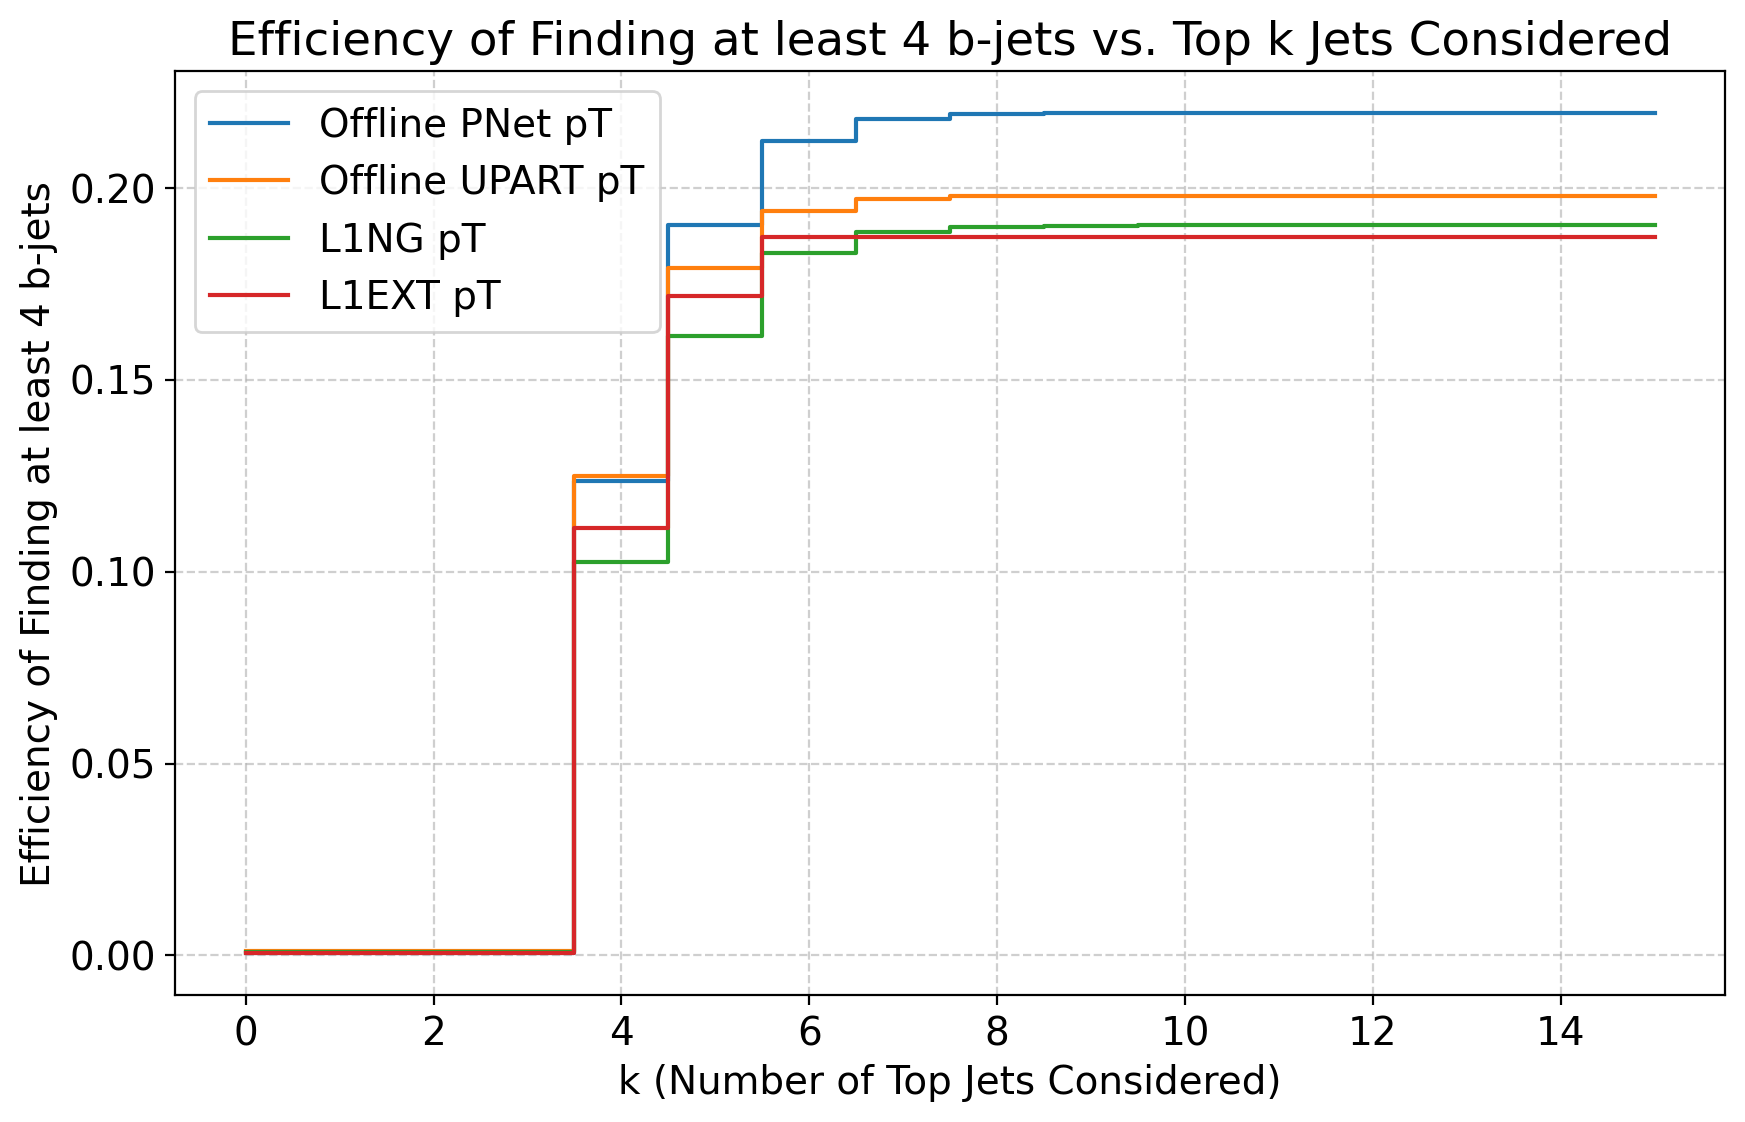

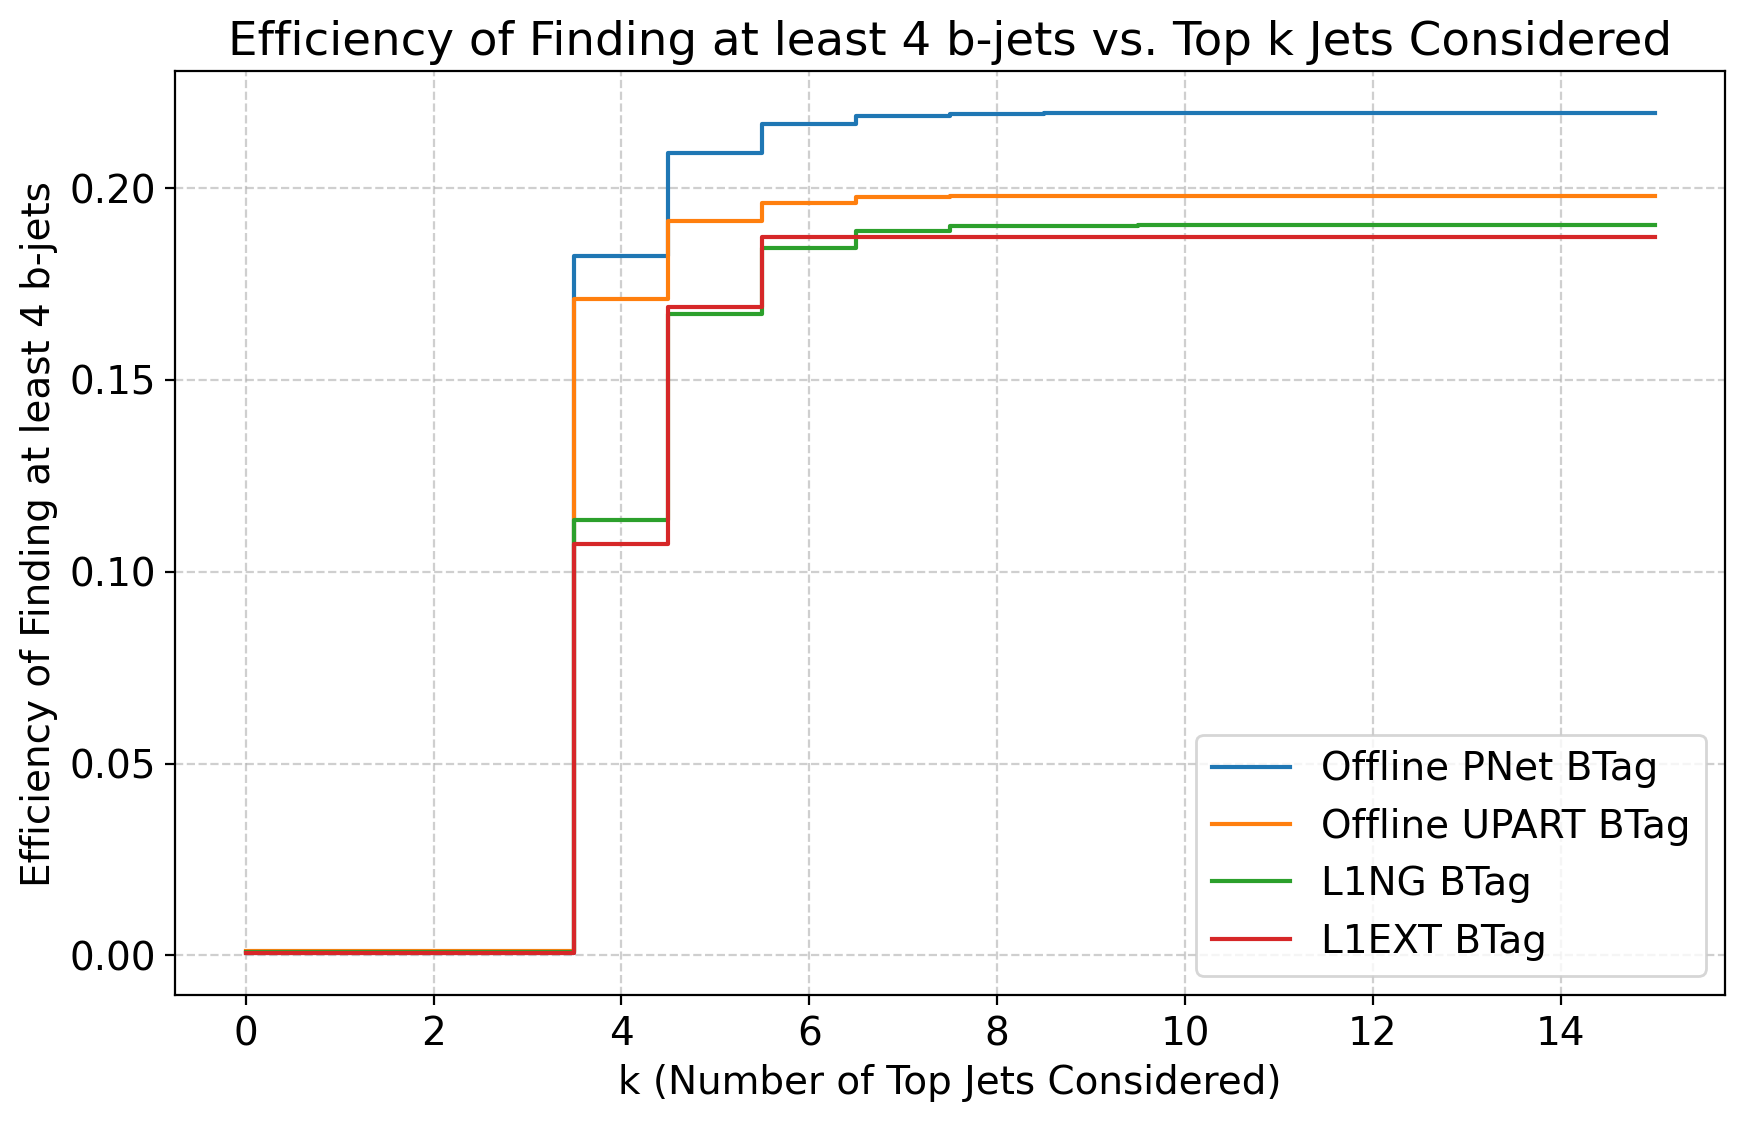

In [5]:
def get_eff_first_jet_pure(gen_b_quarks, reco_jets, tagger_name, n, k):
    """
    Calculates the efficiency of finding at least n pure jets in the top k jets
    ordered by pT and by the specified b-tagging score.
    
    gen_b_quarks: generated b-quarks
    reco_jets: reconstructed jets
    tagger_name: name of the b-tagging score to use for ordering
    n: Number of pure jets to find
    k: Max number of top jets to consider
    -----------
    Returns:
    eff_highest_pt_pure: Efficiency of highest pT jet being pure
    eff_highest_tag_pure: Efficiency of highest b-tagging score jet being pure
    more_than_n_eff_pt: List of efficiencies of finding at least n pure jets in top k jets ordered by pT
    more_than_n_eff_tag: List of efficiencies of finding at least n pure jets in top k jets ordered by b-tagging score
    -----------
    """
    pt_ordered = reco_jets[ak.argsort(reco_jets.vector.pt, ascending=False)]
    tag_ordered = reco_jets[ak.argsort(reco_jets[tagger_name], ascending=False)]

    pt_ordered_purity_idxs = get_pure_jet_idxs_cross_matched(gen_b_quarks, pt_ordered)
    tag_ordered_purity_idxs = get_pure_jet_idxs_cross_matched(gen_b_quarks, tag_ordered)

    # Eff highest pt jet is pure
    num_highest_pt_pure = ak.any(pt_ordered_purity_idxs == 0, axis=1)
    eff_highest_pt_pure = ak.sum(num_highest_pt_pure) / len(gen_b_quarks)
    print(f"Eff highest pt jet is pure: {eff_highest_pt_pure:.4f}")

    # Eff highest btag jet is pure
    num_highest_tag_pure = ak.any(tag_ordered_purity_idxs == 0, axis=1)
    eff_highest_tag_pure = ak.sum(num_highest_tag_pure) / len(gen_b_quarks)
    print(f"Eff highest {tagger_name} jet is pure: {eff_highest_tag_pure:.4f}")

    # Eff finding n pure jets in top k jets considered
    n = 4
    range_k = range(k+1)

    more_than_n_eff_pt = []
    more_than_n_eff_tag = []
    for k in range_k:
        num_k_highest_pt_pure = (
                                    (ak.num(pt_ordered_purity_idxs) == n)  
                                    & (ak.all(pt_ordered_purity_idxs < k, axis=1))
                                    )
        eff_k_highest_pt_pure = ak.sum(num_k_highest_pt_pure) / len(gen_b_quarks)
        more_than_n_eff_pt.append(eff_k_highest_pt_pure)

        num_k_highest_tag_pure = (
                                    (ak.num(tag_ordered_purity_idxs) == n)  
                                    & (ak.all(tag_ordered_purity_idxs < k, axis=1))
                                    )
        eff_k_highest_tag_pure = ak.sum(num_k_highest_tag_pure) / len(gen_b_quarks)
        more_than_n_eff_tag.append(eff_k_highest_tag_pure)

    return eff_highest_pt_pure, eff_highest_tag_pure, more_than_n_eff_pt, more_than_n_eff_tag

    

n = 4  # Number of b-jets to find
k = 15  # Max number of top jets to consider
range_k = range(k+1)

eff_highest_pt_pure_offline, eff_highest_btag_pure_offline, more_than_n_eff_pt_offline, more_than_n_eff_btag_offline = get_eff_first_jet_pure(
    gen_b_quarks, reco_jets_offline, 
    CONFIG["offline"]["tagger_name"], n, k
)
eff_highest_pt_pure_upart, eff_highest_btag_pure_upart, more_than_n_eff_pt_upart, more_than_n_eff_btag_upart = get_eff_first_jet_pure(
    gen_b_quarks, reco_jets_offline_upart, 
    upart_CONFIG["offline"]["tagger_name"], n, k
)
eff_highest_pt_pure_l1ng, eff_highest_btag_pure_l1ng, more_than_n_eff_pt_l1ng, more_than_n_eff_btag_l1ng = get_eff_first_jet_pure(
    gen_b_quarks, reco_jets_l1ng, 
    CONFIG["l1ng"]["tagger_name"], n, k
)
eff_highest_pt_pure_l1ext, eff_highest_btag_pure_l1ext, more_than_n_eff_pt_l1ext, more_than_n_eff_btag_l1ext = get_eff_first_jet_pure(
    gen_b_quarks, reco_jets_l1ext, 
    CONFIG["l1ext"]["tagger_name"], n, k
)


print(f"\nPlotting Top-N Jet Efficiencies for N = {n}...")
plt.figure(figsize=(10, 6))
plt.step(range_k, more_than_n_eff_pt_offline, where='mid', label='Offline PNet pT')
plt.step(range_k, more_than_n_eff_pt_upart, where='mid', label='Offline UPART pT')
plt.step(range_k, more_than_n_eff_pt_l1ng, where='mid', label='L1NG pT')
plt.step(range_k, more_than_n_eff_pt_l1ext, where='mid', label='L1EXT pT')
plt.xlabel("k (Number of Top Jets Considered)")
plt.ylabel(f"Efficiency of Finding at least {n} b-jets")
plt.title(f"Efficiency of Finding at least {n} b-jets vs. Top k Jets Considered")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.step(range_k, more_than_n_eff_btag_offline, where='mid', label='Offline PNet BTag')
plt.step(range_k, more_than_n_eff_btag_upart, where='mid', label='Offline UPART BTag')
plt.step(range_k, more_than_n_eff_btag_l1ng, where='mid', label='L1NG BTag')
plt.step(range_k, more_than_n_eff_btag_l1ext, where='mid', label='L1EXT BTag')
plt.xlabel("k (Number of Top Jets Considered)")
plt.ylabel(f"Efficiency of Finding at least {n} b-jets")
plt.title(f"Efficiency of Finding at least {n} b-jets vs. Top k Jets Considered")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Number of events with at least 4 matched jets: 9176 = 18.35% of total events
Pairing Efficiency: 58.64%
Pairing Efficiency with pairs swapped: 15.62%
Total Pairing Efficiency (including swapped): 74.26%


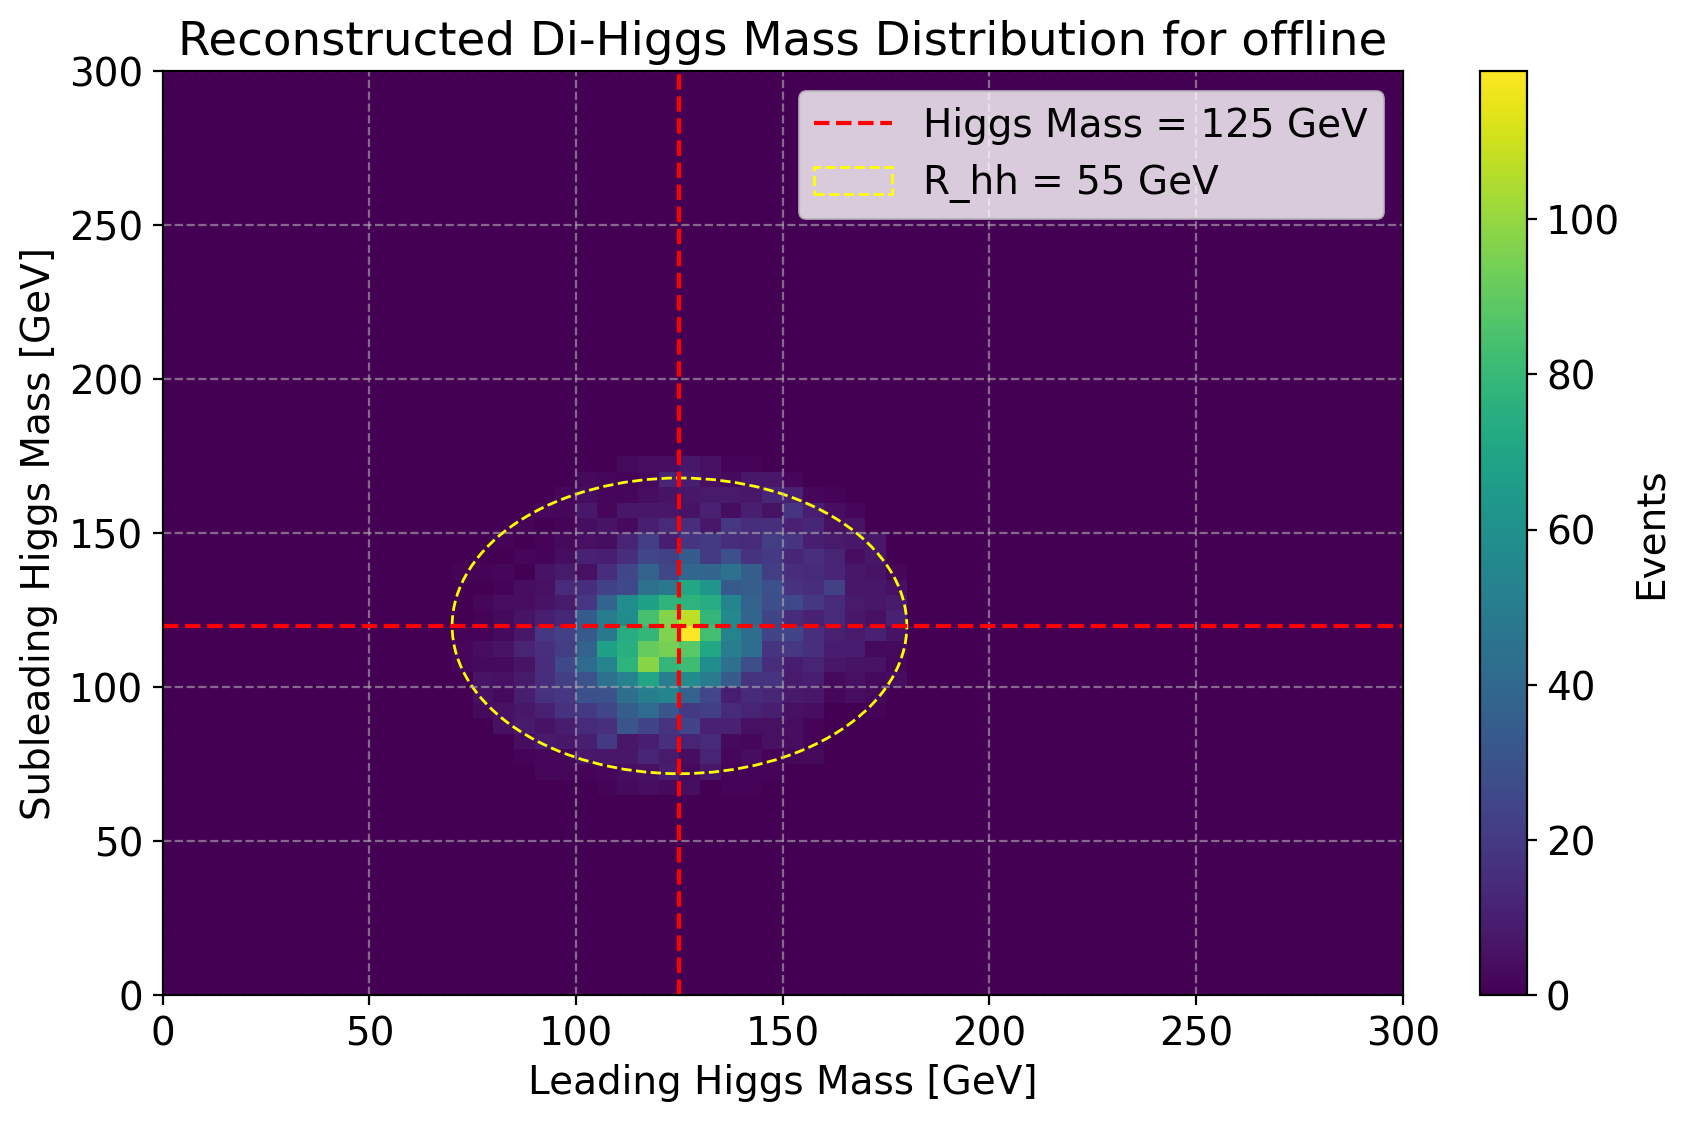

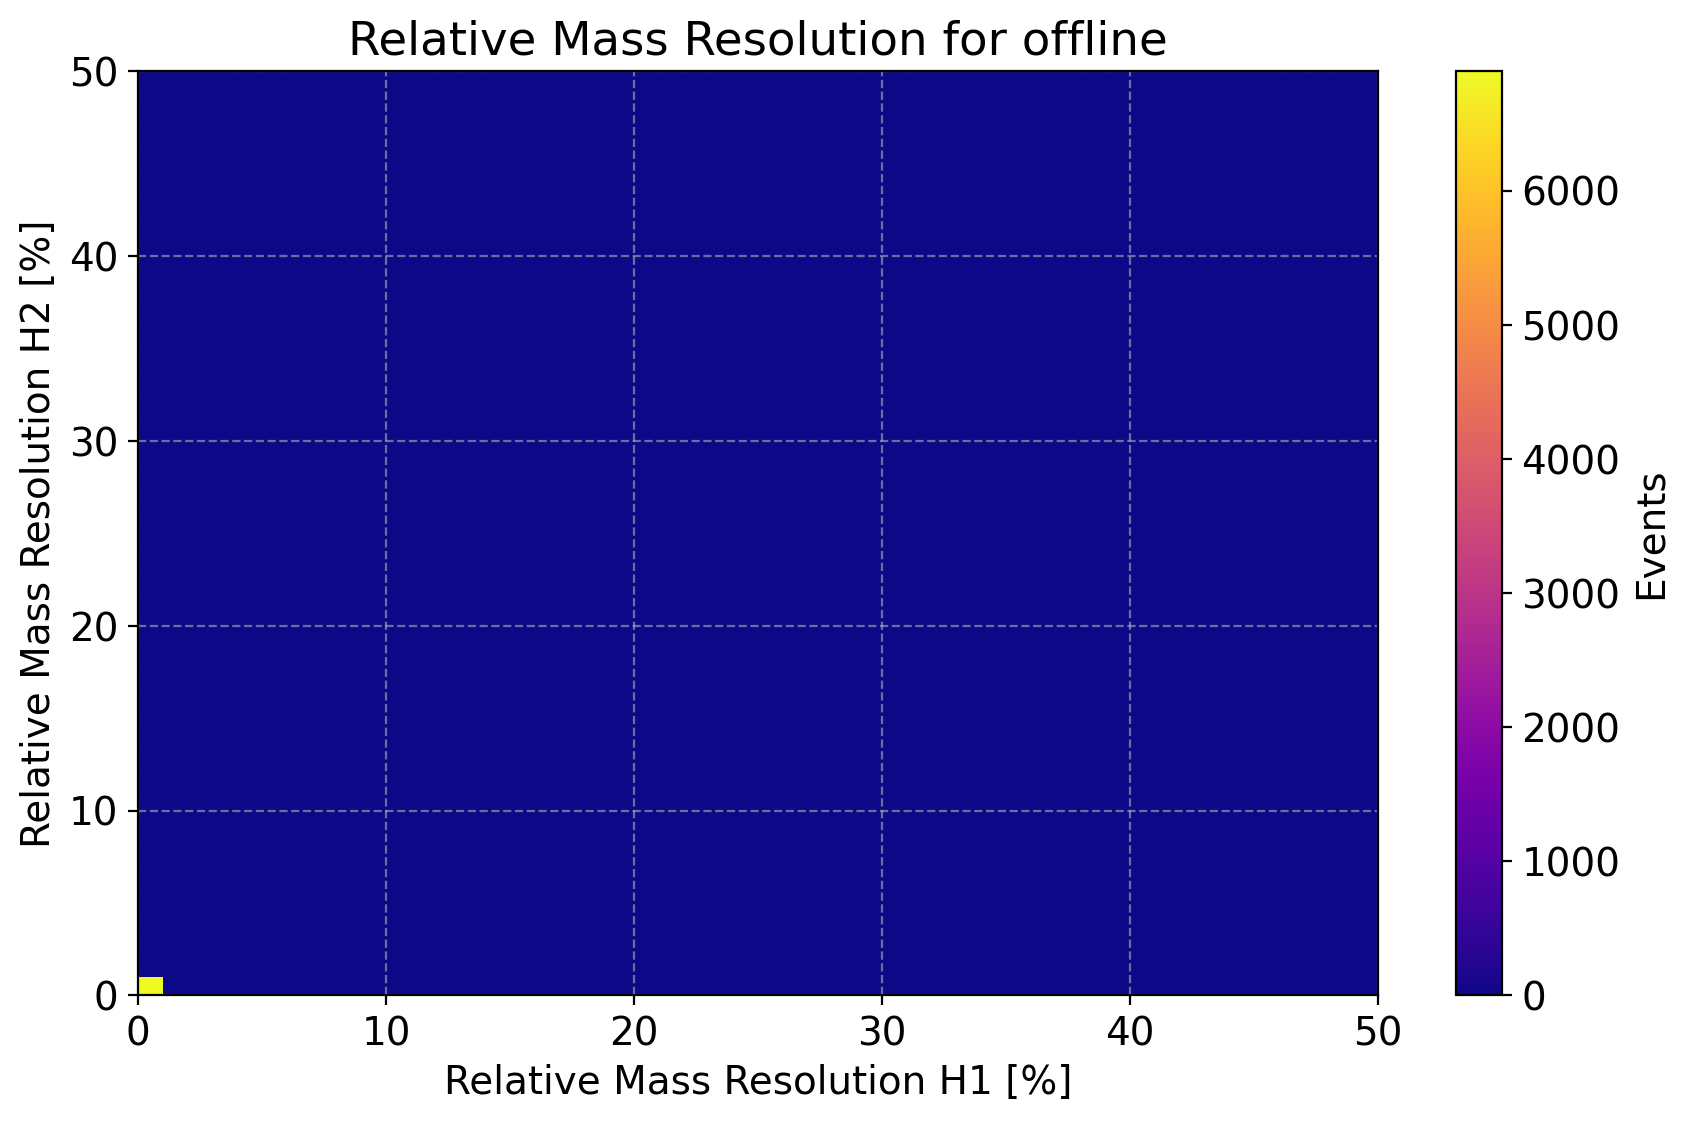

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(60, 60)),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
        220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
        275., 280., 285., 290., 295., 300.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
        220., 225., 230

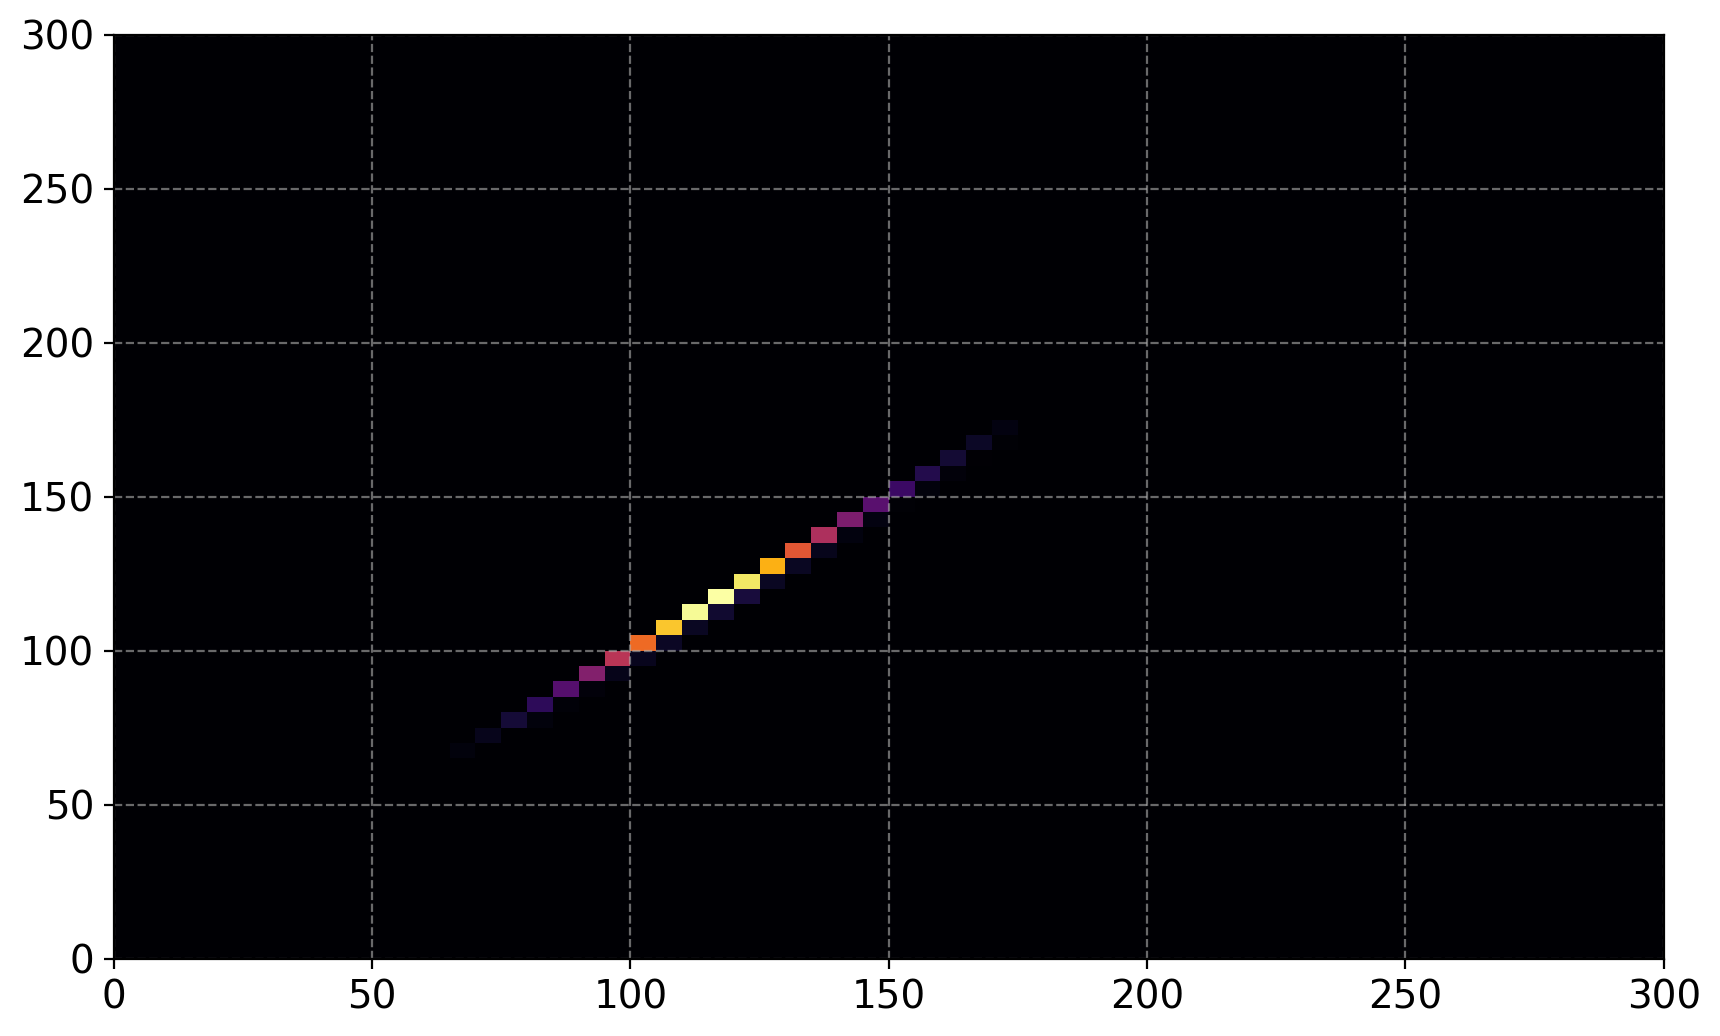

In [6]:
# di Higgs event reconstruction efficiency

reco_jets = reco_jets_offline
tagger_name = CONFIG["offline"]["tagger_name"]
collection_label = "offline"
attr_to_sort_jets = tagger_name
top_k = 4 # only consider leading k jets for di-Higgs reconstruction


# # Select events with at least 4 gen b-quarks
# events_with_4b_mask = ak.num(gen_b_quarks) >= 4
# gen_b_quarks = gen_b_quarks[events_with_4b_mask]
# reco_jets = reco_jets[events_with_4b_mask]
# total_events = len(events_with_4b_mask)
# purity_mask = get_purity_mask_cross_matched(gen_b_quarks, reco_jets)


# from notes
# for pairing efficiency calculation, we need to match jets to gen b-quarks
reco_jets = reco_jets[ak.argsort(reco_jets[attr_to_sort_jets], ascending=False)] # pt_ordered
reco_jets = reco_jets[:, :top_k] # only keep leading k jets for di-Higgs reconstruction
dr_matrix_reco_major = reco_jets[:, :, None].vector.deltaR(gen_b_quarks[:, None, :].vector)
# Find closest GEN quark for each RECO jet. Values are Gen Indices (or None if N_gen=0)
idx_closest_gen_for_reco = ak.argmin(dr_matrix_reco_major, axis=2) # events, n_reco
min_dr_reco_major = ak.fill_none(ak.min(dr_matrix_reco_major, axis=2), np.inf) # events, n_reco

dr_matrix_gen_major = gen_b_quarks[:, :, None].vector.deltaR(reco_jets[:, None, :].vector)
# Find closest RECO jet for each GEN quark. Values are Reco Indices
idx_closest_reco_for_gen = ak.argmin(dr_matrix_gen_major, axis=2) # events, n_gen

# We are indexing (Events, N_gen) using indices of shape (Events, N_reco)
# If idx_closest_gen_for_reco is None (no Gen quarks), this returns None safely.
back_check_reco_idx = idx_closest_reco_for_gen[idx_closest_gen_for_reco]

reco_idxs = ak.local_index(reco_jets, axis=1)
# fill_none(-1) handles the cases where N_gen=0 (where back_check is None)
# so they don't crash the comparison against integer Reco IDs.
pure_cross_matched = (
    (ak.fill_none(back_check_reco_idx, -1) == reco_idxs) & 
    (min_dr_reco_major < CONFIG["matching_cone_size"])
)

gmpr = idx_closest_gen_for_reco[pure_cross_matched] # gen matched to pure reco jets


# di_Higgs matching and reconstruction
matched_jets = reco_jets[pure_cross_matched]
matched_jets = ak.drop_none(matched_jets)
at_least_4_mask = ak.num(matched_jets) >= 4 # event level mask -> need to apply to everything else 
matched_jets = matched_jets[at_least_4_mask] # need at least 4 matched jets for a di-Higgs candidate
print(f"Number of events with at least 4 matched jets: {len(matched_jets)} = {len(matched_jets)/len(reco_jets)*100:.2f}% of total events")

gmpr = gmpr[at_least_4_mask]
clean_gen_b_quarks = gen_b_quarks[at_least_4_mask]
clean_gen_particles = events.GenPart[at_least_4_mask]

def find_gen_b_pairs_with_indices(gmpr, gen_b_quarks, gen_particles):
    """
    Groups matched Gen b-quarks into pairs corresponding to their Higgs parents.
    Sorts the pairs based on the Parent Higgs pT (Leading vs Subleading).
    
    Args:
        gmpr: Indices of matched gen_b_quarks (output of your matching).
        gen_b_quarks: The Gen b-quark collection filtered s.t. there are at least 4 b-quarks per event.
        gen_particles: The global Gen particle collection filtered s.t. there are at least 4 b-quarks per event.

    Returns:
        h1_bs: Array (Events, 2) of GenParticle objects (daughters of Leading Higgs)
        h2_bs: Array (Events, 2) of GenParticle objects (daughters of Subleading Higgs)
        h1_b_idxs: Array (Events, 2) of Global Indices (indices of h1_bs in gen_particles)
        h2_b_idxs: Array (Events, 2) of Global Indices (indices of h2_bs in gen_particles)
    """
    # 1. Get the Matched b-quarks and their Global Indices
    matched_bs = gen_b_quarks[gmpr] # Shape: (Events, 4)
    parent_indices = matched_bs.genPartIdxMother # Shape: (Events, 4)
    
    # 2. Identify the two unique Parent IDs (The two Higgs)
    # We sort the parent indices to easily group them: A A B B
    # But we need to keep track of which b-quark belongs to which parent.
    sorter = ak.argsort(parent_indices, axis=1)
    
    # Reorder the b-quarks and parent_indices so they are grouped by parent
    # Structure: [b_from_H_A, b_from_H_A, b_from_H_B, b_from_H_B]
    sorted_bs = matched_bs[sorter]
    sorted_parents = parent_indices[sorter]
    
    # 3. Separate into Candidates
    # Because we sorted by parent ID, the first 2 are Pair A, the last 2 are Pair B.
    pair_A_bs = sorted_bs[:, 0:2]
    pair_B_bs = sorted_bs[:, 2:4]
    
    # Get the Parent Indices (we only need 1 index per pair to look up the Higgs)
    parent_A_idx = sorted_parents[:, 0:1] # Nested for safety
    parent_B_idx = sorted_parents[:, 2:3]
    
    # 4. Determine Leading/Subleading based on Parent pT
    parent_A = gen_particles[parent_A_idx][:, 0]
    parent_B = gen_particles[parent_B_idx][:, 0]
    
    is_A_leading = parent_A.pt > parent_B.pt # Boolean mask
    
    # 5. Assign Pairs to H1 (Leading) and H2 (Subleading)
    # If A is leading: H1 = Pair A, H2 = Pair B
    # If B is leading: H1 = Pair B, H2 = Pair A
    h1_bs = ak.where(is_A_leading, pair_A_bs, pair_B_bs)
    h2_bs = ak.where(is_A_leading, pair_B_bs, pair_A_bs)
    
    # 6. Get Global Indices of these b-quarks
    # 'gmpr' holds the local index in 'gen_b_quarks'.
    # We need to apply the same 'sorter' and 'is_A_leading' logic to 'gmpr' 
    # to find which original b-quarks went where.
    
    # Sort the original gmpr indices using the same sorter
    sorted_gmpr = gmpr[sorter]
    
    pair_A_gmpr = sorted_gmpr[:, 0:2]
    pair_B_gmpr = sorted_gmpr[:, 2:4]
    
    # Note: These are indices in 'gen_b_quarks', NOT 'gen_particles'. So [{0,1,..,len(gen_b_quarks)-1}, ...]
    h1_local_idxs = ak.where(is_A_leading, pair_A_gmpr, pair_B_gmpr)
    h2_local_idxs = ak.where(is_A_leading, pair_B_gmpr, pair_A_gmpr)
    return h1_bs, h2_bs, h1_local_idxs, h2_local_idxs

# Returns indices of b-quarks belonging to True H1 and True H2 (based on pt ordering of Higgs)
_, _, true_h1_idxs, true_h2_idxs = find_gen_b_pairs_with_indices(gmpr, clean_gen_b_quarks, clean_gen_particles)
# Sort the pairs internally so (2,3) is the same as (3,2)
true_h1_sorted = ak.sort(true_h1_idxs, axis=1)
true_h2_sorted = ak.sort(true_h2_idxs, axis=1)


top_4_jets = matched_jets[:, :4]
j0 = top_4_jets[:, 0]
j1 = top_4_jets[:, 1]
j2 = top_4_jets[:, 2]
j3 = top_4_jets[:, 3]

j0["gen_parent"] = gmpr[:, 0]
j1["gen_parent"] = gmpr[:, 1]
j2["gen_parent"] = gmpr[:, 2]
j3["gen_parent"] = gmpr[:, 3]

p1_c1 = gmpr[:, [0, 1]] # candidate 1 from permutation 1
p1_c2 = gmpr[:, [2, 3]] # candidate 2 from permutation 1

p2_c1 = gmpr[:, [0, 2]] # candidate 1 from permutation 2
p2_c2 = gmpr[:, [1, 3]] # candidate 2 from permutation 2

p3_c1 = gmpr[:, [0, 3]] # candidate 1 from permutation 3
p3_c2 = gmpr[:, [1, 2]] # candidate 2 from permutation 3

p11 = (j0, j1) # candidate 1 from permutation 1
p12 = (j2, j3) # candidate 2 from permutation 1

p21 = (j0, j2) # candidate 1 from permutation 2
p22 = (j1, j3) # candidate 2 from permutation 2

p31 = (j0, j3) # candidate 1 from permutation 3
p32 = (j1, j2) # candidate 2 from permutation 3

h_11_vec = (p11[0].vector + p11[1].vector)
h_12_vec = (p12[0].vector + p12[1].vector)
h_21_vec = (p21[0].vector + p21[1].vector)
h_22_vec = (p22[0].vector + p22[1].vector)
h_31_vec = (p31[0].vector + p31[1].vector)
h_32_vec = (p32[0].vector + p32[1].vector)

all_h1_mass = ak.concatenate([h_11_vec.mass[:, None], h_21_vec.mass[:, None], h_31_vec.mass[:, None]], axis=1) # n, 3
all_h2_mass = ak.concatenate([h_12_vec.mass[:, None], h_22_vec.mass[:, None], h_32_vec.mass[:, None]], axis=1)
d_hh_all_pairs = abs(all_h1_mass - (125.0/120.0) * all_h2_mass) / np.sqrt(1 + (125.0/120.0)**2) # n, 3
min_d_hh_pair = ak.argmin(d_hh_all_pairs, axis=1) # n

cond_0 = (min_d_hh_pair == 0)
cond_1 = (min_d_hh_pair == 1)

raw_h1_vec = ak.where(cond_0, h_11_vec,
                ak.where(cond_1, h_21_vec, h_31_vec))
raw_h2_vec = ak.where(cond_0, h_12_vec,
                ak.where(cond_1, h_22_vec, h_32_vec))

# Select the Jets of the winners
# H1 and H2 Jets
raw_h1_j1 = j0  # j0 is always the first jet of H1 in the scheme
raw_h1_j2 = ak.where(cond_0, j1, 
                ak.where(cond_1, j2, j3))
raw_h2_j1 = ak.where(cond_0, j2, j1) # Logic: if perm0(2), else j1
raw_h2_j2 = ak.where(cond_0, j3, 
                ak.where(cond_1, j3, j2))
# Select the pairs corresponding to the winners
# algo_pair_A is H1 and algo_pair_B is H2
algo_pair_A = ak.where(cond_0[:, None], p1_c1,
                  ak.where(cond_1[:, None], p2_c1, p3_c1))
algo_pair_B = ak.where(cond_0[:, None], p1_c2,
                  ak.where(cond_1[:, None], p2_c2, p3_c2))


# --- Step 3: Apply pt Ordering (Swap H1 and H2 if H2 > H1) ---
is_h1_leading = raw_h1_vec.pt >= raw_h2_vec.pt
# 2. Sort the Jets (Swap the pairs)
# If True: Keep H1 as H1. If False: Swap H1 with H2.
leading_h_j1 = ak.where(is_h1_leading, raw_h1_j1, raw_h2_j1)
leading_h_j2 = ak.where(is_h1_leading, raw_h1_j2, raw_h2_j2)

subleading_h_j1 = ak.where(is_h1_leading, raw_h2_j1, raw_h1_j1)
subleading_h_j2 = ak.where(is_h1_leading, raw_h2_j2, raw_h1_j2)

algo_pair_leading = ak.where(is_h1_leading[:, None], algo_pair_A, algo_pair_B)
algo_pair_subleading = ak.where(is_h1_leading[:, None], algo_pair_B, algo_pair_A)
# 3. Sort them internally (so [3, 2] becomes [2, 3] for comparison)
algo_A_sorted = ak.sort(algo_pair_leading, axis=1)
algo_B_sorted = ak.sort(algo_pair_subleading, axis=1)

leading_h_vector = leading_h_j1.vector + leading_h_j2.vector
subleading_h_vector = subleading_h_j1.vector + subleading_h_j2.vector

# Calculate mass resolution if not L1 collection
if not collection_label.lower().startswith("l1"):
    delta_up_h11_vec = leading_h_j1.vector
    delta_up_h12_vec = leading_h_j2.vector
    delta_down_h11_vec = leading_h_j1.vector
    delta_down_h12_vec = leading_h_j2.vector

    delta_up_h11_vec["pt"] = leading_h_j1.vector.pt + leading_h_j1.PNetRegPtRawRes
    delta_up_h12_vec["pt"] = leading_h_j2.vector.pt + leading_h_j2.PNetRegPtRawRes
    delta_down_h11_vec["pt"] = leading_h_j1.vector.pt - leading_h_j1.PNetRegPtRawRes
    delta_down_h12_vec["pt"] = leading_h_j2.vector.pt - leading_h_j2.PNetRegPtRawRes

    delta_up_h1_vec = delta_up_h11_vec + delta_up_h12_vec
    delta_down_h1_vec = delta_down_h11_vec + delta_down_h12_vec
    sigma_mh1 = np.sqrt((delta_up_h1_vec.mass - leading_h_vector.mass)**2 + (delta_down_h1_vec.mass - leading_h_vector.mass)**2)


    delta_up_h21_vec = subleading_h_j1.vector
    delta_up_h22_vec = subleading_h_j2.vector
    delta_down_h21_vec = subleading_h_j1.vector
    delta_down_h22_vec = subleading_h_j2.vector

    delta_up_h21_vec["pt"] = subleading_h_j1.vector.pt + subleading_h_j1.PNetRegPtRawRes
    delta_up_h22_vec["pt"] = subleading_h_j2.vector.pt + subleading_h_j2.PNetRegPtRawRes
    delta_down_h21_vec["pt"] = subleading_h_j1.vector.pt - subleading_h_j1.PNetRegPtRawRes
    delta_down_h22_vec["pt"] = subleading_h_j2.vector.pt - subleading_h_j2.PNetRegPtRawRes

    delta_up_h2_vec = delta_up_h21_vec + delta_up_h22_vec
    delta_down_h2_vec = delta_down_h21_vec + delta_down_h22_vec
    sigma_mh2 = np.sqrt((delta_up_h2_vec.mass - subleading_h_vector.mass)**2 + (delta_down_h2_vec.mass - subleading_h_vector.mass)**2)

    rel_mass_res_h1 = sigma_mh1 / leading_h_vector.mass
    rel_mass_res_h2 = sigma_mh2 / subleading_h_vector.mass



def R_hh(mh1, mh2):
    return np.sqrt((mh1 - 125.0)**2 + (mh2 - 120.0)**2)

r_hh_selection_mask = R_hh(leading_h_vector.mass, subleading_h_vector.mass) < 55.0



# Check A: Algo A matches Truth H1  AND  Algo B matches Truth H2 (truth ones are sorted by pt already)
match_direct = (
    ak.all(algo_A_sorted == true_h1_sorted, axis=1) & 
    ak.all(algo_B_sorted == true_h2_sorted, axis=1)
)
pair_eff = ak.mean(match_direct)
print(f"Pairing Efficiency: {pair_eff:.2%}")

# Check B: H1 and H2 are swapped in the algo (i.e. Algo A matches Truth H2 and Algo B matches Truth H1)
# This is the swapped case where we assume the algo got the pairs ordered wrong but reconstructed the correct Higgs candidates.
# This is useful to see how often the algo gets the pairs swapped.
match_swapped = (
    ak.all(algo_A_sorted == true_h2_sorted, axis=1) & 
    ak.all(algo_B_sorted == true_h1_sorted, axis=1)
)
# Calculate Efficiency
eff_swapped = ak.mean(match_swapped)
print(f"Pairing Efficiency with pairs swapped: {eff_swapped:.2%}")
print(f"Total Pairing Efficiency (including swapped): {pair_eff + eff_swapped:.2%}")

# Plotting the results
plt.hist2d(
    ak.to_numpy(leading_h_vector[r_hh_selection_mask].mass),
    ak.to_numpy(subleading_h_vector[r_hh_selection_mask].mass),
    bins=[np.linspace(0, 300, 61), np.linspace(0, 300, 61)],
    cmap='viridis',
)

def plot_ellipse(ax, center_x, center_y, width, height, angle, **kwargs):
    from matplotlib.patches import Ellipse
    ellipse = Ellipse(xy=(center_x, center_y), width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)
    
plt.vlines(125, ymin=0, ymax=300, color='red', linestyle='--', label='Higgs Mass = 125 GeV')
plt.hlines(120, xmin=0, xmax=300, color='red', linestyle='--')
ax = plt.gca()
plot_ellipse(ax, 125, 120, 110, 96, 0, edgecolor='yellow', facecolor='none', linestyle='--', label='R_hh = 55 GeV')
plt.title(f"Reconstructed Di-Higgs Mass Distribution for {collection_label}")
plt.xlabel("Leading Higgs Mass [GeV]")
plt.ylabel("Subleading Higgs Mass [GeV]")
plt.colorbar(label="Events")
plt.legend()
plt.show()

plt.hist2d(
    ak.to_numpy(rel_mass_res_h1[r_hh_selection_mask] * 100),
    ak.to_numpy(rel_mass_res_h2[r_hh_selection_mask] * 100),
    bins=[np.linspace(0, 50, 51), np.linspace(0, 50, 51)],
    cmap='plasma',
)
plt.xlabel("Relative Mass Resolution H1 [%]")
plt.ylabel("Relative Mass Resolution H2 [%]")
plt.title(f"Relative Mass Resolution for {collection_label}")
plt.colorbar(label="Events")
plt.show()


plt.hist2d(
    ak.to_numpy((delta_up_h21_vec + delta_up_h22_vec)[r_hh_selection_mask].mass),
    ak.to_numpy((delta_down_h21_vec + delta_down_h22_vec)[r_hh_selection_mask].mass),
    bins=[np.linspace(0, 300, 61), np.linspace(0, 300, 61)],
    cmap='inferno',
)

In [ ]:
# TODO: fix this optmisation code

from scipy.optimize import minimize_scalar
import warnings

def calculate_efficiency_for_cut(reco_jets, gen_b_quarks, tagger_name, cut_value):
    """
    Calculates the b-tagging efficiency for a given cut on the tagger.
    Efficiency = (Number of true b-jets passing the cut) / (Total number of true b-jets)
    """
    # Find which reco jets are actually b-jets
    is_pure_mask = get_purity_mask(gen_b_quarks, reco_jets)
    true_b_jets = reco_jets[is_pure_mask]
    
    # Find how many of those true b-jets pass the cut
    passing_jets = true_b_jets[getattr(true_b_jets, tagger_name) > cut_value]
    
    # Calculate efficiency
    n_passing = ak.sum(ak.num(passing_jets, axis=0))
    n_total = ak.sum(ak.num(true_b_jets, axis=0))
    
    if n_total == 0:
        return 0.0
        
    return n_passing / n_total

def objective_function(cut_value, reco_jets, gen_b_quarks, tagger_name, target_efficiency):
    """
    Objective function for the optimizer.
    Calculates the squared difference between the current and target efficiency.
    """
    current_efficiency = calculate_efficiency_for_cut(reco_jets, gen_b_quarks, tagger_name, cut_value)
    return (current_efficiency - target_efficiency)**2

def find_cut_for_efficiency(reco_jets, gen_b_quarks, tagger_name, target_efficiency):
    """
    Uses scipy.optimize.minimize_scalar to find the b-tag cut value that
    results in the target b-tagging efficiency.
    """
    print(f"Optimizing cut for '{tagger_name}' to achieve {target_efficiency:.1%} efficiency...")
    
    # The optimizer needs a function that takes only the variable to be optimized (cut_value)
    # We use a lambda function to "freeze" the other arguments.
    obj_func = lambda cut: objective_function(cut, reco_jets, gen_b_quarks, tagger_name, target_efficiency)
    
    # We use minimize_scalar to find the minimum of our objective function.
    # This is equivalent to finding where the efficiency is closest to our target.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        result = minimize_scalar(
            obj_func,
            bounds=(0.0, 1.0),  # B-tag scores are between 0 and 1
            method='bounded'
        )
    
    optimal_cut = result.x
    final_efficiency = calculate_efficiency_for_cut(reco_jets, gen_b_quarks, tagger_name, optimal_cut)
    
    print(f"Optimization complete:")
    print(f"  - Target Efficiency: {target_efficiency:.3f}")
    print(f"  - Optimal Cut Value: {optimal_cut:.4f}")
    print(f"  - Resulting Efficiency: {final_efficiency:.3f}")
    print("-" * 30)
    
    return optimal_cut, final_efficiency

# --- Run the Optimization ---

# Ensure we have the necessary data loaded
if 'events' not in locals():
    print("Reloading data as 'events' was not found in the environment.")
    with open("hh-bbbb-obj-config.json", "r") as config_file:
        CONFIG = json.load(config_file)
    events = run_analysis(CONFIG)

# Select gen b-quarks with fiducial cuts
gen_b_quarks_for_opt = select_gen_b_quarks_from_higgs(events)
gen_b_quarks_for_opt = gen_b_quarks_for_opt[
    (gen_b_quarks_for_opt.pt > CONFIG["gen"]["pt_cut"]) & 
    (abs(gen_b_quarks_for_opt.eta) < CONFIG["gen"]["eta_cut"])
]

# Get the reconstructed jet collections
reco_jets_offline_for_opt = events[CONFIG["offline"]["collection_name"]]
reco_jets_l1_for_opt = events[CONFIG["l1"]["collection_name"]]

# --- Define Target Efficiencies and Run ---
target_eff_offline = 0.70  # e.g., 70%
target_eff_l1 = 0.70       # e.g., 50%

# Find the optimal cut for the Offline jets
optimal_cut_offline, final_eff_offline = find_cut_for_efficiency(
    reco_jets_offline_for_opt,
    gen_b_quarks_for_opt,
    CONFIG["offline"]["tagger_name"],
    target_eff_offline
)

# Find the optimal cut for the L1 jets
optimal_cut_l1, final_eff_l1 = find_cut_for_efficiency(
    reco_jets_l1_for_opt,
    gen_b_quarks_for_opt,
    CONFIG["l1"]["tagger_name"],
    target_eff_l1
)
